# Setup

In [28]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, XLMRobertaConfig, BertModel, get_linear_schedule_with_warmup
from transformers.modeling_utils import PretrainedConfig
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, naive_bayes, pipeline
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import random
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from utils.functions import group_texts, lrn_code, topic_code,subcode_trans, extract_code,  party_deu, clean_text, copy_weights, subcode_trans
from utils.functions import train_loop, eval_loop, test_loop, tokenize_function, cmp_scale, scale_func, d2v_reduct, check_weights_similar, party_group_func
from utils.models import TIPredictWithAttention
from sklearn.utils.class_weight import compute_class_weight
from safetensors.torch import load_file
import pickle
import nltk
from sklearn.decomposition import PCA
from huggingface_hub import login
from peft import PeftModel, PeftConfig
#nltk.download('stopwords') ## Remove comments and do it once if you haven't

In [29]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [30]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)


# Small test of BERT embeddings

In [4]:
model_name = 'bert-base-cased'

In [5]:
model = BertModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
sentence_a = 'I went to the river bank'
sentence_b = 'I went to the bank by the river'
tok_a = tokenizer(sentence_a, return_tensors='pt')
tok_b = tokenizer(sentence_b, return_tensors='pt')

In [7]:
tok_a

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 2186, 3085,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
tok_b

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 3085, 1118, 1103, 2186,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
with torch.no_grad():
    outputs_a = model(**tok_a)
    outputs_b = model(**tok_b)
# Extract word embeddings from the last hidden layer
last_hidden_states_a = outputs_a.last_hidden_state
last_hidden_states_b = outputs_b.last_hidden_state

# Extract the word embedding for the first token (CLS token)
word_embedding_a = last_hidden_states_a[:, -2, :] ## 0 is the CLS token, river is the last token
word_embedding_b = last_hidden_states_b[:, 5, :]

In [10]:
np.corrcoef(word_embedding_a.numpy(), word_embedding_b.numpy()).round(2)

array([[1.  , 0.64],
       [0.64, 1.  ]])

# Implementation

### Data preparation

In [11]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [12]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code == 'H')].reset_index(drop=True)

In [13]:
manifesto['code_long'] = manifesto['code'].apply(subcode_trans)
manifesto['code_extract'] = manifesto['code_long'].astype(str).apply(extract_code)



In [14]:
manifesto['lrn'] = manifesto.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto['topic'] = manifesto['code_extract'].apply(topic_code)

In [15]:
manifesto.groupby('lrn').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,topic
lrn,,,,,,,,,,,,,
left,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675,455675
neutral,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228,263228
right,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419,124419


In [16]:
manifesto.groupby('topic').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn
topic,,,,,,,,,,,,,
Agriculture,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495
Civil Rights,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272,98272
Decentralization,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834,42834
Defense,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392,14392
Economy,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409,86409
Education,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364,43364
Environment,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961,91961
European integration,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567,19567
Immigration,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729,28729


In [17]:
len(manifesto[manifesto.lrn=="right"])/len(manifesto)*100 ## minority group: 14.8%

14.75343937428408

In [18]:
len(manifesto[manifesto.topic=="Defense"])/len(manifesto)*100 ## minority group: 1.7%

1.7065841991552457

In [19]:
texts = manifesto['text'].tolist()

In [20]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 17.97537002473551
Std length (word) is: 11.163519592598034
Min length (word) is: 1
Max length (word) is: 269


<Axes: >

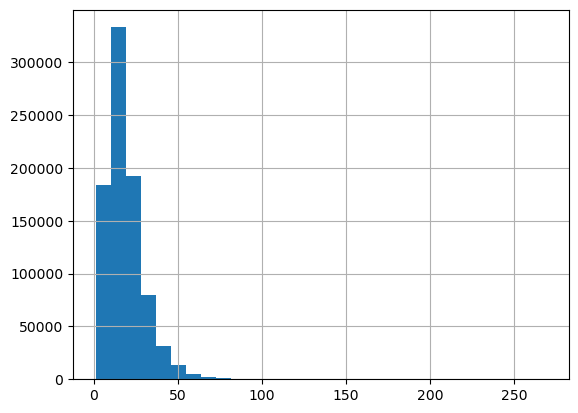

In [21]:
pd.Series(seq_len).hist(bins = 30)

In [35]:
len([x for x in seq_len if x < 5])/len(seq_len)*100

4.096893001724134

In [15]:
results = group_texts(manifesto, 
                      ['countryname','election','party','code_long'], 'text', 
                      max_group_factor = 5)

In [16]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [17]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [18]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'code_long']

In [19]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500


In [20]:
manifesto_regrouped.loc[:,'code_extract'] = manifesto_regrouped['code_long'].apply(extract_code)
manifesto_regrouped.loc[:,'lrn'] = manifesto_regrouped.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['code_extract'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)
manifesto_regrouped.loc[:,'country_party_election'] = manifesto_regrouped.country.str.cat([manifesto_regrouped.party.astype(str), manifesto_regrouped.election.astype(str)], sep='_')
manifesto_regrouped.loc[:,'text_added'] = manifesto_regrouped.text + ' ' + manifesto_regrouped.country_party_election

In [21]:
len(set(manifesto_regrouped['country_party_election']))

710

In [22]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic,country_party_election,text_added
lrn,,,,,,,,,,
left,174280,174280,174280,174280,174280,174280,174280,174280,174280,174280
neutral,99942,99942,99942,99942,99942,99942,99942,99942,99942,99942
right,48108,48108,48108,48108,48108,48108,48108,48108,48108,48108


In [23]:
texts = manifesto_regrouped['text_added'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 74.92853597245059
Std length (word) is: 36.832940962522976
Min length (word) is: 2
Max length (word) is: 375


In [24]:
texts[0]

'Statt dessen soll ein Freiwilligen-Milizheer geschaffen werden. Auch so wird eine Heeresstruktur gewahrt, die sich aus einem deutlich abgespeckten Berufskader und aus einer Miliz zusammensetzt. Austria_42110_1999'

<Axes: >

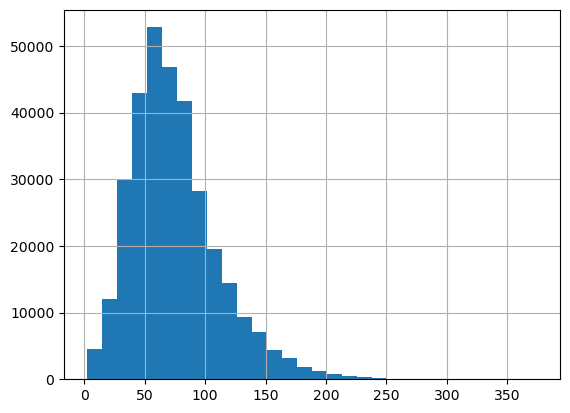

In [25]:
pd.Series(seq_len).hist(bins = 30)

In [26]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8', index=False)
manifesto.to_csv('data/temps/manifesto.csv', encoding='utf-8', index=False)

### Fine-tuning with manual left-right-neutral scheme (Kluever + CMP); grouped data

In [4]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [77]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic,country_party_election,text_added
lrn,,,,,,,,,,
left,174280,174280,174280,174280,174280,174280,174280,174280,174280,174280
neutral,99942,99942,99942,99942,99942,99942,99942,99942,99942,99942
right,48108,48108,48108,48108,48108,48108,48108,48108,48108,48108


In [71]:
manifesto_regrouped.groupby('topic').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,country_party_election,text_added
topic,,,,,,,,,,
Agriculture,7972,7972,7972,7972,7972,7972,7972,7972,7972,7972
Civil Rights,37479,37479,37479,37479,37479,37479,37479,37479,37479,37479
Decentralization,16498,16498,16498,16498,16498,16498,16498,16498,16498,16498
Defense,5343,5343,5343,5343,5343,5343,5343,5343,5343,5343
Economy,33145,33145,33145,33145,33145,33145,33145,33145,33145,33145
Education,16732,16732,16732,16732,16732,16732,16732,16732,16732,16732
Environment,35083,35083,35083,35083,35083,35083,35083,35083,35083,35083
European integration,7732,7732,7732,7732,7732,7732,7732,7732,7732,7732
Immigration,11025,11025,11025,11025,11025,11025,11025,11025,11025,11025


In [72]:
manifesto_regrouped.groupby('party').count()

,text,country_election_party_code,country,election,code_long,code_extract,lrn,topic,country_party_election,text_added
party,,,,,,,,,,
11110,573,573,573,573,573,573,573,573,573,573
11220,703,703,703,703,703,703,703,703,703,703
11320,574,574,574,574,574,574,574,574,574,574
11420,960,960,960,960,960,960,960,960,960,960
11520,401,401,401,401,401,401,401,401,401,401
...,...,...,...,...,...,...,...,...,...,...
53420,966,966,966,966,966,966,966,966,966,966
53520,2564,2564,2564,2564,2564,2564,2564,2564,2564,2564
53620,1972,1972,1972,1972,1972,1972,1972,1972,1972,1972


In [15]:
manifesto_reduced = manifesto_regrouped[['topic','lrn','text', 'country']].reset_index(drop=True)

In [16]:
manifesto_reduced['topic_lrn'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['lrn']

In [7]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [17]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('country')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_lrn')



Casting to class labels:   0%|          | 0/322330 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/322330 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/322330 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/322330 [00:00<?, ? examples/s]

In [9]:
## Save class labels
import pickle
topic_labels = manifesto_dataset.features['topic'].names
file_path = 'data/temps/topic_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(topic_labels, fp)

In [18]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_lrn', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_lrn', seed=seed_val )

In [19]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'lrn', 'text', 'country', 'topic_lrn'],
        num_rows: 203067
    })
    test: Dataset({
        features: ['topic', 'lrn', 'text', 'country', 'topic_lrn'],
        num_rows: 32233
    })
    eval: Dataset({
        features: ['topic', 'lrn', 'text', 'country', 'topic_lrn'],
        num_rows: 87030
    })
})

In [20]:
train_set = manifesto_datasets['train'].to_pandas()
train_set.groupby('lrn').count()

,topic,text,country,topic_lrn
lrn,,,,
0,109795,109795,109795,109795
1,62963,62963,62963,62963
2,30309,30309,30309,30309


In [39]:
cw_lr = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.lrn), y=train_set.lrn)
cw_lr

array([0.61650348, 1.07505996, 2.23329704])

In [40]:
cw_topic = compute_class_weight(class_weight='balanced', classes = np.unique(train_set.topic), y=train_set.topic)
cw_topic

array([3.36895282, 0.71671043, 1.62792208, 5.02740642, 0.81041377,
       1.60522197, 0.76567802, 3.4740813 , 2.43625828, 2.39624044,
       0.37314774, 0.39428342])

In [73]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_lrn'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/203067 [00:00<?, ? examples/s]

Map:   0%|          | 0/32233 [00:00<?, ? examples/s]

Map:   0%|          | 0/87030 [00:00<?, ? examples/s]

['topic', 'lrn', 'input_ids', 'attention_mask']

In [74]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=32, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=32, shuffle=False, collate_fn = data_collator)

In [82]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [83]:
topic_count = len(set(manifesto_regrouped['topic']))
lr_count = len(set(manifesto_regrouped['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count).to(device)



In [45]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
loss_fn_topic = nn.CrossEntropyLoss(weight= torch.tensor(cw_topic, device=device).type(torch.float32))
loss_fn_lr = nn.CrossEntropyLoss(weight= torch.tensor(cw_lr, device=device).type(torch.float32))
loss_fn_reconstruct = nn.MSELoss()

In [46]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device,topic_var='topic', lr_var='lrn',train_topic=True)
    eval_loop(eval_dataloader, model, loss_fn_topic, loss_fn_lr, loss_fn_reconstruct, device, topic_var='topic', lr_var='lrn',train_topic=True)
 
    

Epoch: 1

Training...
loss: 1.503658  [16000/203067]. Took 0:03:07
loss: 1.347492  [32000/203067]. Took 0:06:10
loss: 1.206049  [48000/203067]. Took 0:09:28
loss: 1.115914  [64000/203067]. Took 0:12:56
loss: 1.053055  [80000/203067]. Took 0:16:14
loss: 1.005502  [96000/203067]. Took 0:19:30
loss: 0.970036  [112000/203067]. Took 0:22:50
loss: 0.940494  [128000/203067]. Took 0:26:05
loss: 0.916172  [144000/203067]. Took 0:29:14
loss: 0.895291  [160000/203067]. Took 0:32:21
loss: 0.876319  [176000/203067]. Took 0:35:31
loss: 0.860532  [192000/203067]. Took 0:38:40

  Training epoch took: 0:40:50
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.605776 

Test Error: 
 Accuracy - LRN: 62.6, Avg loss: 0.605776 

Test Error: 
 Accuracy - Topic: 76.5, Avg loss: 0.605776 

Epoch: 2

Training...
loss: 0.626729  [16000/203067]. Took 0:03:01
loss: 0.622066  [32000/203067]. Took 0:06:02
loss: 0.613612  [48000/203067]. Took 0:09:06
loss: 0.609957  [64000/203067]. Took 0:12:08
loss: 0.605605  [80000/203067]

In [47]:
model.save_pretrained('results/multilingual/manifesto_tlrrp/')
tokenizer.save_pretrained('results/multilingual/manifesto_tlrrp/') 

('results/multilingual/manifesto_tlrrp/tokenizer_config.json',
 'results/multilingual/manifesto_tlrrp/special_tokens_map.json',
 'results/multilingual/manifesto_tlrrp/tokenizer.json')

### Scaling party positions in Germany

#### Reload files and compute LR-score by MARPOR for comparison

In [32]:
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')

In [33]:
manifesto_deu = manifesto[manifesto.countryname == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [34]:
manifesto_deu_rgr.loc[:,'party_election'] = manifesto_deu_rgr.party.astype(str).str.cat([manifesto_deu_rgr.election.astype(str)],sep="_")

In [58]:
manifesto_deu.loc[manifesto_deu.lrn=='right','topic']

6        Decentralization
9        Decentralization
19       Decentralization
20       Decentralization
21       Decentralization
               ...       
81852             Economy
81853         Immigration
81854         Immigration
81863         Environment
81865         Environment
Name: topic, Length: 11178, dtype: object

In [53]:
manifesto_deu_rgr.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,text_added
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Es ist Zeit für einen Wechsel Politik kann nic...
1,Die Bundesrepublik Deutschland ist von Zersied...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Die Bundesrepublik Deutschland ist von Zersied...
2,– einschließlich einer drastischen Reduzierung...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,– einschließlich einer drastischen Reduzierung...
3,Sie schaffen nicht mehr Sicherheit Die Immunit...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Sie schaffen nicht mehr Sicherheit Die Immunit...
4,Es ist zwar das schärfste Mittel gegen Straftä...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Es ist zwar das schärfste Mittel gegen Straftä...


In [10]:
manifesto_deu.groupby('party').count()

,text,election,code,pos,party_code,country,countryname,name,name_english,code_long,code_extract,lrn,topic
party,,,,,,,,,,,,,
41113,22494,22494,22494,22494,22494,22494,22494,22494,22494,22494,22494,22494,22494
41221,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758
41222,573,573,573,573,573,573,573,573,573,573,573,573,573
41223,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929,12929
41320,12886,12886,12886,12886,12886,12886,12886,12886,12886,12886,12886,12886,12886
41420,14116,14116,14116,14116,14116,14116,14116,14116,14116,14116,14116,14116,14116
41521,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306
41912,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363
41952,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794,1794


In [35]:
lr_kws = dict({'left': 'left', 'right': 'right'})

In [36]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, text_var = 'text', group_vars=['party','election'], lr_kws = lr_kws, sent_var='lrn')

#### Scaling positions with ContextScale

In [37]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)


In [38]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [39]:
topic_count = len(set(manifesto_deu_rgr['topic']))
lr_count = len(set(manifesto_deu_rgr['lrn']))

In [40]:
## Load pre-trained models
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [41]:
manifesto_reduced = manifesto_deu_rgr[['text', 'lrn','topic','party_election']]

In [42]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('party_election')


Casting to class labels:   0%|          | 0/30987 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30987 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30987 [00:00<?, ? examples/s]

In [43]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, remove_columns=['text'])
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/30987 [00:00<?, ? examples/s]

In [44]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [45]:
position_scores, pred_topics, pred_lrs = scale_func(full_dataloader, scaling_model, device, reg_value=0.15, topic_label=None)

Start predicting labels...
Labels for topic are not provided. Using predicted topic labels for position scaling instead!
Start computing position scores


In [48]:
manifesto_deu_rgr['lr_score_cs'] = position_scores.flatten()
manifesto_deu_rgr['pred_topics'] = pred_topics
manifesto_deu_rgr['pred_lrn'] = pred_lrs

In [49]:
columns  =['party', 'election','mean_score', 'se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_deu_rgr.groupby(['party','election']):
    mean_score = group['lr_score_cs'].mean()
    se_score = group['lr_score_cs'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [50]:
df['lr_log'] = logscale
df['lr_abs'] = absscale

In [51]:
np.corrcoef(df['lr_abs'], df['mean_score'])

array([[1.       , 0.9563943],
       [0.9563943, 1.       ]])

In [52]:
df.loc[:,'party_name'] = df['party'].apply(party_deu)
df = df[df.party_name != 'Other']
df.loc[:,'election'] = df['election'].astype(int)

In [53]:
df

,party,election,mean_score,se_score,lr_log,lr_abs,party_name
0,41113,1998,-0.465437,0.019082,-2.111447,-0.544173,Alliance 90/Greens
1,41113,2002,-0.358099,0.025726,-1.924930,-0.509639,Alliance 90/Greens
2,41113,2005,-0.362580,0.027125,-1.883445,-0.501073,Alliance 90/Greens
3,41113,2009,-0.371877,0.015490,-2.140401,-0.551157,Alliance 90/Greens
4,41113,2013,-0.474642,0.012602,-2.129241,-0.562799,Alliance 90/Greens
5,41113,2017,-0.485085,0.015116,-2.837880,-0.678452,Alliance 90/Greens
6,41113,2021,-0.495645,0.012058,-2.599334,-0.610127,Alliance 90/Greens
7,41221,1998,-0.406577,0.027491,-2.285000,-0.526258,The Left
8,41221,2002,-0.501560,0.029774,-1.840069,-0.517773,The Left
9,41222,2005,-0.462782,0.032848,-2.129016,-0.588133,The Left


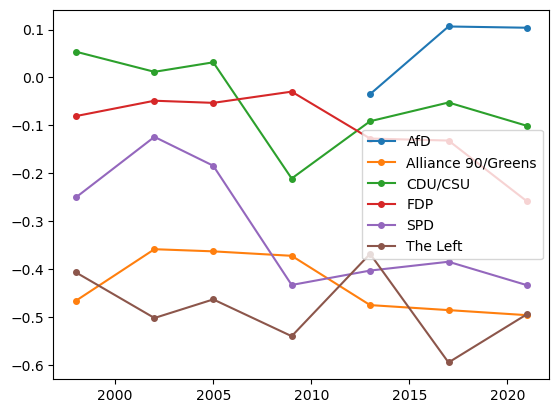

In [54]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party_name'):
    ax.plot(group.election, group.mean_score, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [55]:
## Save df 
df.to_csv('data/py_outputs/cs_gen.csv', index=False)

In [56]:
manifesto_deu_rgr.loc[:, 'pred_topics'] = manifesto_deu_rgr['pred_topics'].astype(int)


In [57]:
with open("data/temps/topic_labels", "rb") as fp:   # Unpickling
   topic_labels = pickle.load(fp)

In [58]:
name_topic_dict = dict([(x,y) for x,y in enumerate(topic_labels)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [59]:
manifesto_deu_rgr.loc[:, 'pred_topic_name']= manifesto_deu_rgr['pred_topics'].map(name_topic_dict)

In [60]:
manifesto_deu_rgr.loc[:,'party_name'] = manifesto_deu_rgr['party'].astype(str).apply(party_deu)


In [61]:
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_name != 'Other'].reset_index(drop=True)
manifesto_deu_rgr.loc[:,'election'] = manifesto_deu_rgr['election'].astype(int)

In [62]:
manifesto_deu_rgr

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,text_added,party_election,lr_score_cs,pred_topics,pred_lrn,pred_topic_name,party_name
0,Es ist Zeit für einen Wechsel Politik kann nic...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Es ist Zeit für einen Wechsel Politik kann nic...,41113_1998,0.598788,2,2,Decentralization,Alliance 90/Greens
1,Die Bundesrepublik Deutschland ist von Zersied...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Die Bundesrepublik Deutschland ist von Zersied...,41113_1998,-0.300594,10,1,Other,Alliance 90/Greens
2,– einschließlich einer drastischen Reduzierung...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,– einschließlich einer drastischen Reduzierung...,41113_1998,-0.074135,10,1,Other,Alliance 90/Greens
3,Sie schaffen nicht mehr Sicherheit Die Immunit...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Sie schaffen nicht mehr Sicherheit Die Immunit...,41113_1998,0.126982,1,1,Civil Rights,Alliance 90/Greens
4,Es ist zwar das schärfste Mittel gegen Straftä...,Germany_1998_41113_0,Germany,1998,41113,0,0,neutral,Other,Germany_41113_1998,Es ist zwar das schärfste Mittel gegen Straftä...,41113_1998,0.118058,1,1,Civil Rights,Alliance 90/Greens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29742,Die Hälfte der niedergelassenen Ärzte erreicht...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral,Other,Germany_41953_2021,Die Hälfte der niedergelassenen Ärzte erreicht...,41953_2021,-0.268904,11,1,Social Welfare,AfD
29743,3. Finanzielle und organisatorische Niederlass...,Germany_2021_41953_70400,Germany,2021,41953,70400,704,neutral,Other,Germany_41953_2021,3. Finanzielle und organisatorische Niederlass...,41953_2021,-0.190066,11,0,Social Welfare,AfD
29744,Die AfD bekennt sich ausdrücklich zur Fürsor...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,left,Civil Rights,Germany_41953_2021,Die AfD bekennt sich ausdrücklich zur Fürsor...,41953_2021,-0.885594,1,0,Civil Rights,AfD
29745,Um echte Teilhabe für behinderte Menschen am ...,Germany_2021_41953_70500,Germany,2021,41953,70500,705,left,Civil Rights,Germany_41953_2021,Um echte Teilhabe für behinderte Menschen am ...,41953_2021,-0.904999,1,0,Civil Rights,AfD


In [63]:
manifesto_deu_rgr.to_csv("data/py_outputs/cs_topic.csv", index=False)

# Validity checks

### Same dataset

#### Test set

In [64]:
## Load pre-trained models
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [75]:
pred_topics, pred_sent = test_loop(test_dataloader, scaling_model, device=device)

In [76]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [77]:
test_set = manifesto_datasets['test'].to_pandas()

In [78]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [79]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.83,0.79,0.88,0.88
1,0.82,0.82,0.82,0.82
2,0.83,0.79,0.86,0.86
3,0.91,0.89,0.94,0.94
4,0.80,0.79,0.82,0.82
5,0.88,0.84,0.93,0.93
6,0.89,0.88,0.90,0.90
7,0.89,0.86,0.92,0.92
8,0.79,0.75,0.84,0.84
9,0.87,0.86,0.89,0.89


In [80]:
round(res_table.mean(axis=0),2)

f1           0.85
precision    0.84
recall       0.87
accuracy     0.87
dtype: float64

In [81]:
list_names = manifesto_datasets['train'].features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [82]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_topic'] = predicted_topics
res_table

,f1,precision,recall,accuracy,topic_name
0,0.83,0.79,0.88,0.88,Agriculture
1,0.82,0.82,0.82,0.82,Civil Rights
2,0.83,0.79,0.86,0.86,Decentralization
3,0.91,0.89,0.94,0.94,Defense
4,0.80,0.79,0.82,0.82,Economy
5,0.88,0.84,0.93,0.93,Education
6,0.89,0.88,0.90,0.90,Environment
7,0.89,0.86,0.92,0.92,European integration
8,0.79,0.75,0.84,0.84,Immigration
9,0.87,0.86,0.89,0.89,International politics


In [83]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [84]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.91,0.91,0.91,0.91
1,0.87,0.88,0.86,0.86
2,0.81,0.78,0.83,0.83


In [85]:
round(res_table.mean(axis=0),2)

f1           0.86
precision    0.86
recall       0.87
accuracy     0.87
dtype: float64

In [86]:
list_names = manifesto_datasets['train'].features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [87]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_lrn'] = predicted_sent
res_table

,f1,precision,recall,accuracy,lrn
0,0.91,0.91,0.91,0.91,left
1,0.87,0.88,0.86,0.86,neutral
2,0.81,0.78,0.83,0.83,right


In [88]:
test_set

,topic,lrn,text,topic_lrn,pred_topic,pred_lrn
0,11,0,Cela nécessite la déprogrammation de certains ...,23,11,0
1,11,0,"Forslaget finansieres igennem råderummet, som ...",23,11,0
2,5,0,Onderwijs is en blijft de springplank naar suc...,12,5,0
3,0,1,20.Fjerne alle samarbeidsbegrensninger. Fremsk...,1,4,2
4,1,1,"Així mateix, s’ha de valorar el reconeixement ...",4,1,1
...,...,...,...,...,...,...
32228,7,0,Voorbeelden daarvan zijn defensie en buitenlan...,16,7,0
32229,11,0,Voor ieder van ons is er de verantwoordelijkhe...,23,11,0
32230,5,0,Daarom willen wij het voor werkgevers mogelijk...,12,5,0
32231,10,1,Freiheit bedeutet auch tiefere Steuern und Abg...,22,10,1


In [89]:
test_set.to_csv('results/classification results/manifesto_test_pred.csv', index=False, encoding='utf-8')

#### Different languages

In [90]:
manifesto_test = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8")

In [250]:
manifesto_test

,text,election,code,pos,party_code,country,party,countryname,name,name_english
0,정의당 성장전략 그린뉴딜경제,2020,H,1,113322_202004,113,113322,South Korea,Jeongui Dang,Justice Party
1,"다른 성장, 미래와의 동맹 그린뉴딜경제로 한국사회 대전환을 이루겠습니다",2020,H,2,113322_202004,113,113322,South Korea,Jeongui Dang,Justice Party
2,"방향도, 비전도 없이 표류하고 있는 한국경제",2020,408,3,113322_202004,113,113322,South Korea,Jeongui Dang,Justice Party
3,성장률이 2% 내외로 주저앉은 한국 경제는 새로운 성장 동력을 찾지 못한 채 표 류...,2020,410,4,113322_202004,113,113322,South Korea,Jeongui Dang,Justice Party
4,대를 이어 지속되고 있는 부동산 불패신화로 자산 불평등은 심 화되고 청년들은 희망을...,2020,503,5,113322_202004,113,113322,South Korea,Jeongui Dang,Justice Party
...,...,...,...,...,...,...,...,...,...,...
97166,"Не отдадим тем, кто хочет разрушить её, не отд...",2011,601,187,94951_201112,94,94951,Russia,Edinaya Rossiya,United Russia
97167,"Россия должна принадлежать свободным, порядочн...",2011,606,188,94951_201112,94,94951,Russia,Edinaya Rossiya,United Russia
97168,"Уверены, так и будет.",2011,305,189,94951_201112,94,94951,Russia,Edinaya Rossiya,United Russia
97169,Будущее за нами!,2011,305,190,94951_201112,94,94951,Russia,Edinaya Rossiya,United Russia


In [91]:
manifesto_test = manifesto_test[(manifesto_test.code.notna()) & ~(manifesto_test.code == 'H')].reset_index(drop=True)

In [92]:
manifesto_test['code_long'] = manifesto_test['code'].apply(subcode_trans)
manifesto_test['code_extract'] = manifesto_test['code_long'].astype(str).apply(extract_code)



In [93]:
manifesto_test['lrn'] = manifesto_test.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_test['topic'] = manifesto_test['code_extract'].apply(topic_code)

In [94]:
results = group_texts(manifesto_test, 
                      ['countryname','election','party','code_long'], 'text', 
                      max_group_factor = 5)

In [95]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [96]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [97]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'code_long']

In [20]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long
0,Za základ považujeme povinnou školní docházku....,Czech Republic_2002_82320_0,Czech Republic,2002,82320,0
1,Proto chceme modernizovat armádu - Profesional...,Czech Republic_2002_82320_10400,Czech Republic,2002,82320,10400
2,Chceme prosadit zrušení základní vojenské služ...,Czech Republic_2002_82320_10500,Czech Republic,2002,82320,10500
3,"- Prosazujeme vstup do EU tak, aby se ČR stala...",Czech Republic_2002_82320_10800,Czech Republic,2002,82320,10800
4,"- Těm, kdo chtějí zkusit štěstí v zahraničí, o...",Czech Republic_2002_82320_10800,Czech Republic,2002,82320,10800


In [98]:
manifesto_regrouped.loc[:,'code_extract'] = manifesto_regrouped['code_long'].apply(extract_code)
manifesto_regrouped.loc[:,'lrn'] = manifesto_regrouped.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['code_extract'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)
manifesto_regrouped.loc[:,'country_party_election'] = manifesto_regrouped.country.str.cat([manifesto_regrouped.party.astype(str), manifesto_regrouped.election.astype(str)], sep='_')
manifesto_regrouped.loc[:,'text_added'] = manifesto_regrouped.text + ' ' + manifesto_regrouped.country_party_election

In [99]:
manifesto_regrouped.groupby('lrn').count()

,text,country_election_party_code,country,election,party,code_long,code_extract,topic,country_party_election,text_added
lrn,,,,,,,,,,
left,14350,14350,14350,14350,14350,14350,14350,14350,14350,14350
neutral,13549,13549,13549,13549,13549,13549,13549,13549,13549,13549
right,7075,7075,7075,7075,7075,7075,7075,7075,7075,7075


In [100]:
manifesto_reduced = manifesto_regrouped[['topic','lrn','text']].reset_index(drop=True)

In [101]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [102]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')



Casting to class labels:   0%|          | 0/34974 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/34974 [00:00<?, ? examples/s]

In [103]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 400}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/34974 [00:00<?, ? examples/s]

In [104]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [105]:
## Load pre-trained models
topic_count = len(set(manifesto_reduced['topic']))
lr_count = len(set(manifesto_reduced['lrn']))
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [106]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [107]:
pred_topics, pred_sent = test_loop(full_dataloader, scaling_model, device=device)

In [108]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [109]:
test_set = manifesto_dataset.to_pandas()

In [110]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [111]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.82,0.81,0.82,0.82
1,0.76,0.74,0.78,0.78
2,0.71,0.64,0.80,0.80
3,0.84,0.81,0.87,0.87
4,0.77,0.82,0.74,0.74
5,0.87,0.81,0.95,0.95
6,0.78,0.77,0.79,0.79
7,0.86,0.82,0.91,0.91
8,0.75,0.68,0.84,0.84
9,0.82,0.79,0.86,0.86


In [112]:
round(res_table.mean(axis=0),2)

f1           0.80
precision    0.78
recall       0.83
accuracy     0.83
dtype: float64

In [113]:
list_names = manifesto_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [114]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_topic'] = predicted_topics
res_table

,f1,precision,recall,accuracy,topic_name
0,0.82,0.81,0.82,0.82,Agriculture
1,0.76,0.74,0.78,0.78,Civil Rights
2,0.71,0.64,0.80,0.80,Decentralization
3,0.84,0.81,0.87,0.87,Defense
4,0.77,0.82,0.74,0.74,Economy
5,0.87,0.81,0.95,0.95,Education
6,0.78,0.77,0.79,0.79,Environment
7,0.86,0.82,0.91,0.91,European integration
8,0.75,0.68,0.84,0.84,Immigration
9,0.82,0.79,0.86,0.86,International politics


In [115]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [116]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.85,0.84,0.85,0.85
1,0.85,0.86,0.84,0.84
2,0.74,0.73,0.76,0.76


In [117]:
round(res_table.mean(axis=0),2)

f1           0.81
precision    0.81
recall       0.82
accuracy     0.82
dtype: float64

In [118]:
list_names = manifesto_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [119]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_lrn'] = predicted_sent
res_table

,f1,precision,recall,accuracy,lrn
0,0.85,0.84,0.85,0.85,left
1,0.85,0.86,0.84,0.84,neutral
2,0.74,0.73,0.76,0.76,right


In [120]:
test_set

,topic,lrn,text,pred_topic,pred_lrn
0,10,1,Za základ považujeme povinnou školní docházku....,10,1
1,3,2,Proto chceme modernizovat armádu - Profesional...,3,2
2,3,0,Chceme prosadit zrušení základní vojenské služ...,3,0
3,7,0,"- Prosazujeme vstup do EU tak, aby se ČR stala...",7,0
4,7,0,"- Těm, kdo chtějí zkusit štěstí v zahraničí, o...",7,0
...,...,...,...,...,...
34969,1,0,Her dört kişiden birinin genç olduğu ülkemizde...,1,0
34970,1,0,Saadet Partisinin “bizim” vurgusu yapacağı tek...,1,0
34971,1,0,Gençliği hesaba katmadan veya müşteri göSEÇİM ...,1,0
34972,1,0,Gençlerimizi zehirleyen ve toplumsal yapıyı bo...,1,0


In [121]:
test_set.to_csv('results/classification results/manifesto_lang_pred.csv', index=False, encoding='utf-8')

### COALITIONAGREE, same coding style

In [122]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [123]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

#### No supervision

In [124]:
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [125]:
results = group_texts(coalitionagree, ['country','cabinet_year','category3'], 'sentence', max_group_factor = 5)

In [126]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split('_', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'code']
coalition_regrouped['code_short'] = coalition_regrouped['code'].apply(extract_code)

In [165]:
coalition_regrouped.head()

,text,labels,country,year,code,code_short
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506


In [127]:
coalition_regrouped['lrn'] = coalition_regrouped.apply(lambda x: lrn_code(x['code'], x['code_short']), axis=1)
coalition_regrouped['topic'] = coalition_regrouped['code_short'].apply(topic_code)

In [167]:
coalition_regrouped.groupby('lrn').count()

,text,labels,country,year,code,code_short,topic
lrn,,,,,,,
left,17997,17997,17997,17997,17997,17997,17997
neutral,15257,15257,15257,15257,15257,15257,15257
right,6033,6033,6033,6033,6033,6033,6033


In [168]:
coalition_regrouped

,text,labels,country,year,code,code_short,lrn,topic
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education
...,...,...,...,...,...,...,...,...
39282,Sverige ska säkra de nationella minoriteternas...,Sweden_2014_70501,Sweden,2014,70501,705,left,Civil Rights
39283,Personer med funktionsnedsättning ska ha möjli...,Sweden_2014_70502,Sweden,2014,70502,705,left,Civil Rights
39284,hbtq-personer,Sweden_2014_70503,Sweden,2014,70503,705,left,Civil Rights
39285,"särskilt kvinnor, Insatser för kvinnors egenfö...",Sweden_2014_70602,Sweden,2014,70602,706,left,Civil Rights


In [128]:
cagree_reduced = coalition_regrouped[['lrn', 'topic','text']]

In [129]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [130]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_lrn'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [131]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [132]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [134]:
pred_topics, pred_lrn = test_loop(full_dataloader, scaling_model, device=device)

In [135]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_lrn = np.concatenate([i.cpu().detach().numpy() for i in pred_lrn])

In [136]:
test_set = cagree_dataset.to_pandas()

In [137]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [138]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.78,0.71,0.88,0.88
1,0.75,0.74,0.76,0.76
2,0.58,0.47,0.74,0.74
3,0.84,0.84,0.83,0.83
4,0.71,0.66,0.76,0.76
5,0.80,0.78,0.83,0.83
6,0.80,0.79,0.80,0.80
7,0.79,0.75,0.84,0.84
8,0.69,0.63,0.78,0.78
9,0.81,0.74,0.90,0.90


In [139]:
round(res_table.mean(axis=0),2)

f1           0.76
precision    0.73
recall       0.80
accuracy     0.80
dtype: float64

In [140]:
list_names = cagree_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [141]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_topic'] = predicted_topics
res_table

,f1,precision,recall,accuracy,topic_name
0,0.78,0.71,0.88,0.88,Agriculture
1,0.75,0.74,0.76,0.76,Civil Rights
2,0.58,0.47,0.74,0.74,Decentralization
3,0.84,0.84,0.83,0.83,Defense
4,0.71,0.66,0.76,0.76,Economy
5,0.80,0.78,0.83,0.83,Education
6,0.80,0.79,0.80,0.80,Environment
7,0.79,0.75,0.84,0.84,European integration
8,0.69,0.63,0.78,0.78,Immigration
9,0.81,0.74,0.90,0.90,International politics


In [142]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_lrn, average=None)
matrix = confusion_matrix(labels, predicted_lrn)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [143]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.81,0.82,0.81,0.81
1,0.78,0.82,0.74,0.74
2,0.66,0.60,0.75,0.75


In [144]:
round(res_table.mean(axis=0),2)

f1           0.75
precision    0.75
recall       0.77
accuracy     0.77
dtype: float64

In [145]:
list_names = cagree_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [146]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_lrn'] = predicted_lrn
res_table

,f1,precision,recall,accuracy,lrn
0,0.81,0.82,0.81,0.81,left
1,0.78,0.82,0.74,0.74,neutral
2,0.66,0.60,0.75,0.75,right


In [147]:
test_set

,lrn,topic,text,pred_topic,pred_lrn
0,1,10,"Abmachungen über die Beamtenbesoldung, ebenso...",10,1
1,1,10,"Der Gemeinde Wien soll, wenn die Sozialistisch...",1,0
2,2,2,über die Behandlung der Nationalsozialisten,8,1
3,0,4,sowie über die Verstaatlichung werden in Aussi...,4,2
4,0,5,Die Schaffung eines einheitlichen Dienst- und ...,10,1
...,...,...,...,...,...
39282,0,1,Sverige ska säkra de nationella minoriteternas...,8,0
39283,0,1,Personer med funktionsnedsättning ska ha möjli...,1,0
39284,0,1,hbtq-personer,1,0
39285,0,1,"särskilt kvinnor, Insatser för kvinnors egenfö...",1,0


In [148]:
test_set.to_csv('results/classification results/cagree_nosup_pred.csv', index=False, encoding='utf-8')

#### 25% supervision

In [149]:
cagree_reduced.loc[:,'topic_lrn'] = cagree_reduced.loc[:,'topic'] + '_' + cagree_reduced.loc[:,'lrn']

C:\Users\vhnh1\AppData\Local\Temp\ipykernel_9996\2383038560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cagree_reduced.loc[:,'topic_lrn'] = cagree_reduced.loc[:,'topic'] + '_' + cagree_reduced.loc[:,'lrn']


In [150]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')
cagree_dataset = cagree_dataset.class_encode_column('topic_lrn')

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [151]:
train_test = cagree_dataset.train_test_split(test_size=0.75, stratify_by_column='topic_lrn', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='topic_lrn', seed=seed_val )

In [152]:
cagree_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
cagree_datasets

DatasetDict({
    train: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 7856
    })
    test: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 29466
    })
    eval: Dataset({
        features: ['lrn', 'topic', 'text', 'topic_lrn'],
        num_rows: 1965
    })
})

In [153]:
train_set = cagree_datasets['train'].to_pandas()
train_set.groupby('lrn').count()

,topic,text,topic_lrn
lrn,,,
0,3598,3598,3598
1,3050,3050,3050
2,1208,1208,1208


In [154]:
class_counts_lr = train_set.groupby('lrn').count()['topic']
cw_lr = np.array(1/np.sqrt(class_counts_lr+1e-6))
cw_lr =  cw_lr/ np.sum(cw_lr)
cw_lr

array([0.26233268, 0.28492664, 0.45274067])

In [155]:
class_counts_topic = train_set.groupby('topic').count()['lrn']
cw_topic = np.array(1/np.sqrt(class_counts_topic+1e-6))
cw_topic =  cw_topic/ np.sum(cw_topic)
cw_topic

array([0.11706064, 0.06218154, 0.08925252, 0.12155226, 0.05352895,
       0.08298965, 0.0649465 , 0.11767192, 0.12021648, 0.09484531,
       0.03312005, 0.04263419])

In [156]:
tokenized_datasets = cagree_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_lrn'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/7856 [00:00<?, ? examples/s]

Map:   0%|          | 0/29466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1965 [00:00<?, ? examples/s]

['lrn', 'topic', 'input_ids', 'attention_mask']

In [157]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=32, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=32, shuffle=False, collate_fn = data_collator)

In [158]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [160]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
model.load_state_dict(loaded_tensors)
scaling_model=None

In [161]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_lr = nn.CrossEntropyLoss(weight=torch.tensor(cw_lr, device=device).type(torch.float32))
criterion_topic =  nn.CrossEntropyLoss(weight=torch.tensor(cw_topic, device=device).type(torch.float32))

In [162]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, criterion_lr, criterion_topic, device,topic_var='topic', lr_var='lrn')
    eval_loop(eval_dataloader, model, criterion_lr, criterion_topic, device, lr_var='lrn', topic_var='topic')
 
    

Epoch: 1

Training...
loss: 0.604992  [ 1600/ 7856].
Elapsed time: 0:00:18, Estimated remaining time: 0:01:12
loss: 0.581652  [ 3200/ 7856].
Elapsed time: 0:00:36, Estimated remaining time: 0:00:53
loss: 0.566596  [ 4800/ 7856].
Elapsed time: 0:00:54, Estimated remaining time: 0:00:34
loss: 0.559422  [ 6400/ 7856].
Elapsed time: 0:01:12, Estimated remaining time: 0:00:16

  Training epoch took: 0:01:28
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.479908 

Test Error: 
 Accuracy - LRN: 82.9, Avg loss: 0.479908 

Test Error: 
 Accuracy - Topic: 82.9, Avg loss: 0.479908 

Epoch: 2

Training...
loss: 0.426092  [ 1600/ 7856].
Elapsed time: 0:00:18, Estimated remaining time: 0:01:12
loss: 0.412038  [ 3200/ 7856].
Elapsed time: 0:00:36, Estimated remaining time: 0:00:53
loss: 0.410279  [ 4800/ 7856].
Elapsed time: 0:00:55, Estimated remaining time: 0:00:35
loss: 0.411708  [ 6400/ 7856].
Elapsed time: 0:01:12, Estimated remaining time: 0:00:16

  Training epoch took: 0:01:28
Test Error: 
 Accura

In [163]:
model.save_pretrained('results/multilingual/cagree_tlrrp_25/')
tokenizer.save_pretrained('results/multilingual/cagree_tlrrp_25/') 

('results/multilingual/cagree_tlrrp_25/tokenizer_config.json',
 'results/multilingual/cagree_tlrrp_25/special_tokens_map.json',
 'results/multilingual/cagree_tlrrp_25/sentencepiece.bpe.model',
 'results/multilingual/cagree_tlrrp_25/added_tokens.json',
 'results/multilingual/cagree_tlrrp_25/tokenizer.json')

In [164]:
## Load pre-trained models
topic_count = len(set(cagree_reduced['topic']))
lr_count = len(set(cagree_reduced['lrn']))
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/cagree_tlrrp_25/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [166]:
pred_topics, pred_sent = test_loop(test_dataloader, scaling_model, device=device)

In [167]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_sent = np.concatenate([i.cpu().detach().numpy() for i in pred_sent])

In [168]:
test_set = cagree_datasets['test'].to_pandas()

In [169]:
labels = test_set['topic'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_topics, average=None)
matrix = confusion_matrix(labels, predicted_topics)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [170]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.84,0.80,0.88,0.88
1,0.82,0.80,0.84,0.84
2,0.74,0.69,0.79,0.79
3,0.88,0.87,0.89,0.89
4,0.79,0.78,0.80,0.80
5,0.88,0.86,0.90,0.90
6,0.86,0.85,0.88,0.88
7,0.86,0.82,0.91,0.91
8,0.77,0.71,0.85,0.85
9,0.87,0.86,0.89,0.89


In [171]:
round(res_table.mean(axis=0),2)

f1           0.84
precision    0.82
recall       0.86
accuracy     0.86
dtype: float64

In [172]:
list_names = cagree_datasets['train'].features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'Agriculture',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Defense',
 4: 'Economy',
 5: 'Education',
 6: 'Environment',
 7: 'European integration',
 8: 'Immigration',
 9: 'International politics',
 10: 'Other',
 11: 'Social Welfare'}

In [173]:
res_table['topic_name'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_topic'] = predicted_topics
res_table

,f1,precision,recall,accuracy,topic_name
0,0.84,0.80,0.88,0.88,Agriculture
1,0.82,0.80,0.84,0.84,Civil Rights
2,0.74,0.69,0.79,0.79,Decentralization
3,0.88,0.87,0.89,0.89,Defense
4,0.79,0.78,0.80,0.80,Economy
5,0.88,0.86,0.90,0.90,Education
6,0.86,0.85,0.88,0.88,Environment
7,0.86,0.82,0.91,0.91,European integration
8,0.77,0.71,0.85,0.85,Immigration
9,0.87,0.86,0.89,0.89,International politics


In [174]:
labels = test_set['lrn'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_sent, average=None)
matrix = confusion_matrix(labels, predicted_sent)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [175]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.88,0.88,0.88,0.88
1,0.88,0.89,0.87,0.87
2,0.74,0.73,0.76,0.76


In [176]:
round(res_table.mean(axis=0),2)

f1           0.83
precision    0.83
recall       0.84
accuracy     0.84
dtype: float64

In [177]:
list_names = cagree_datasets['train'].features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [178]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
test_set['pred_lrn'] = predicted_sent
res_table

,f1,precision,recall,accuracy,lrn
0,0.88,0.88,0.88,0.88,left
1,0.88,0.89,0.87,0.87,neutral
2,0.74,0.73,0.76,0.76,right


In [179]:
test_set.to_csv('results/classification results/cagree_25sup_pred.csv', index=False, encoding='utf-8')

#### Scale the entire corpus with 25% training

In [185]:
cagree_reduced

,lrn,topic,text,topic_lrn
0,neutral,Other,"Abmachungen über die Beamtenbesoldung, ebenso...",Other_neutral
1,neutral,Other,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Other_neutral
2,right,Decentralization,über die Behandlung der Nationalsozialisten,Decentralization_right
3,left,Economy,sowie über die Verstaatlichung werden in Aussi...,Economy_left
4,left,Education,Die Schaffung eines einheitlichen Dienst- und ...,Education_left
...,...,...,...,...
39282,left,Civil Rights,Sverige ska säkra de nationella minoriteternas...,Civil Rights_left
39283,left,Civil Rights,Personer med funktionsnedsättning ska ha möjli...,Civil Rights_left
39284,left,Civil Rights,hbtq-personer,Civil Rights_left
39285,left,Civil Rights,"särskilt kvinnor, Insatser för kvinnors egenfö...",Civil Rights_left


In [180]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [189]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text', 'topic_lrn'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [190]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)

In [192]:
position_scores, pred_topics, pred_lrs = scale_func(full_dataloader, scaling_model, device, reg_value=0.15, topic_label=None)

Start predicting labels...
Labels for topic are not provided. Using predicted topic labels for position scaling instead!
Elapsed time: 0:05:12, Estimated remaining time: 0:01:12
Start computing position scores


In [193]:
cagree_25 = coalition_regrouped.copy()

In [194]:
cagree_25.loc[:,'position_scores_25'] = position_scores.flatten()
cagree_25.loc[:,'pred_topics_25'] = pred_topics
cagree_25.loc[:,'pred_lr_25'] = pred_lrs



In [195]:
labels = cagree_dataset['lrn']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_lrs, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [196]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.89,0.89,0.89,0.89
1,0.89,0.90,0.89,0.89
2,0.77,0.76,0.78,0.78


In [200]:
labels = cagree_dataset['topic']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_topics, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [201]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.85,0.82,0.89,0.08
1,0.83,0.82,0.85,0.66
2,0.77,0.72,0.82,0.20
3,0.89,0.88,0.90,0.00
4,0.81,0.80,0.82,0.00
5,0.90,0.87,0.92,0.00
6,0.88,0.86,0.89,0.00
7,0.88,0.84,0.92,0.00
8,0.79,0.73,0.87,0.00
9,0.89,0.87,0.90,0.00


In [202]:
cagree_25.head()

,text,labels,country,year,code,code_short,lrn,topic,position_scores_25,pred_topics_25,pred_lr_25
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other,0.104967,10,1
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other,-0.187312,2,1
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization,-0.186863,10,0
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy,-0.129844,4,0
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education,-0.934641,5,0


In [203]:
cagree_25.to_csv('data/py_outputs/cagree_scaled_25.csv', index=False)

### MOTN dataset, different coding style

#### Adaptation training - 25%

In [204]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [205]:
motn_trump = pd.read_csv('data/MOTN/MOTN_responses_groundtruth.csv', encoding='utf-8')

In [284]:
motn_trump.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [285]:
len(motn_trump)

7146

In [206]:
_,_,f1_org,_ = precision_recall_fscore_support(y_pred=motn_trump['BERT_stance'].tolist(), y_true=motn_trump['trump_stance_auto'].tolist())
f1_org.mean(axis=0).round(2)

0.81

In [207]:
motn_trump_reduced = motn_trump[['edits_clean_text','trump_stance_auto']]

In [208]:
motn_dataset = Dataset.from_pandas(motn_trump_reduced)
motn_dataset = motn_dataset.class_encode_column('trump_stance_auto')


Stringifying the column:   0%|          | 0/7146 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/7146 [00:00<?, ? examples/s]

In [209]:
train_test = motn_dataset.train_test_split(test_size=0.75, seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.1, seed=seed_val )

In [210]:
motn_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
motn_datasets

DatasetDict({
    train: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 1607
    })
    test: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 5360
    })
    eval: Dataset({
        features: ['edits_clean_text', 'trump_stance_auto'],
        num_rows: 179
    })
})

In [213]:
train_set = motn_datasets['train'].to_pandas()
train_set.groupby('trump_stance_auto').count()

,edits_clean_text
trump_stance_auto,
0,979
1,628


In [214]:
class_counts_lr = train_set.groupby('trump_stance_auto').count()['edits_clean_text']
cw_lr = np.array(1/np.sqrt(class_counts_lr+1e-6))
cw_lr =  cw_lr/ np.sum(cw_lr)
cw_lr

array([0.44472787, 0.55527213])

In [215]:
tokenized_datasets = motn_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'edits_clean_text', 'max_length': 300}, 
                                            remove_columns=['edits_clean_text'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/5360 [00:00<?, ? examples/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

['trump_stance_auto', 'input_ids', 'attention_mask']

In [216]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=32, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=32, shuffle=False, collate_fn = data_collator)

In [217]:
## Retrieve layers up until the lr_count
topic_count = 12 ## number of classes for topic
lr_count = 3 ## number of classes for ideology
source_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_tlrrp/model.safetensors')
source_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [218]:
target_model = TLRRPredict(config, model_name, topic_count, lr_count=2, lora=True).to(device)


In [ ]:
architecture1 = get_architecture_details(target_model)
architecture2 = get_architecture_details(source_model)

In [ ]:
compare_architectures(architecture1, architecture2)

Difference found in layer mlp2.8:
Model 1: {'name': 'mlp2.8', 'type': 'Linear', 'params': 1040}
Model 2: {'name': 'mlp2.8', 'type': 'Linear', 'params': 1560}


False

In [232]:
copy_weights(source_model, target_model, patterns=("mlp2.8"))

Skipping mlp2.8.weight as it is not present or should be skipped in the scaling model.
Skipping mlp2.8.bias as it is not present or should be skipped in the scaling model.


In [252]:
check_weights_similar(source_model, target_model, patterns=("mlp2"))

All parameters copied successfully.


In [250]:
n_epochs=6
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(target_model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_lr = nn.CrossEntropyLoss(weight=torch.tensor(cw_lr, device=device).type(torch.float32))



In [251]:
import random
import time
import datetime
from torch.cuda.amp import GradScaler, autocast

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def train_loop(dataloader, model, optimizer, scheduler, criterion_lr, criterion_topic,device, lr_var, 
               accumulation_steps=4,sparse_fraction=0.5,alpha=0.1,topic_var=None):
    print("")
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    scaler = GradScaler()
    # Put the model into training mode. 
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    # For each batch of training data...optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    for batch_num, batch in enumerate(dataloader):
      batch = {k: v.to(device) for k,v in batch.items()}
      optimizer.zero_grad()
      with autocast():
        logits_topic, logits_lr = model(input_ids = batch['input_ids'], 
                                        attention_mask = batch['attention_mask'])
        y_lr = batch[lr_var].long()
        loss_lr = criterion_lr(logits_lr, y_lr)
        if topic_var is not None:
            y_topic = batch[topic_var].long()
            loss_topic = criterion_topic(logits_topic, y_topic)
            loss = 0.5*loss_topic  + 0.5*loss_lr 
            train_loss += loss.item()

        else:
            loss = loss_lr
            train_loss += loss.item()
        ## Calculate a topic-aware variance loss
        if ((batch_num+1) % accumulation_steps == 0 or (batch_num+1) == len(dataloader)) and topic_var is not None:
            unique_topics, topic_counts = y_topic.unique(return_counts=True)
            variance_loss = 0.0 
            selected_topics = random.sample(list(unique_topics), int(sparse_fraction * len(unique_topics)))
            for topic in selected_topics:
                count = topic_counts[unique_topics == topic]
                if count > 1:
                    topic_indices = (y_topic == topic).nonzero(as_tuple=True)[0]
                    topic_ideology_logits = logits_lr[topic_indices]
                    variance_loss += torch.var(topic_ideology_logits, dim=0).mean()

            # Add the regularization term to the loss
            total_loss_with_reg = loss + alpha * variance_loss
            scaler.scale(total_loss_with_reg).backward()
        else:
            scaler.scale(loss).backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
      scaler.step(optimizer)
      scaler.update()
      #loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      #optimizer.step()
      scheduler.step()
     
      # Report
      if batch_num % 100 == 0 and batch_num != 0:
        elapsed = time.time() - t0
        avg_batch_time = elapsed / batch_num
        estimated_total_time = avg_batch_time * len(dataloader)
        estimated_remaining_time = estimated_total_time - elapsed
        current_loss = train_loss/batch_num
        current = batch_num * len(batch['input_ids'])
        print(f"loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}].")
        print(f"Elapsed time: {format_time(elapsed)}, Estimated remaining time: {format_time(estimated_remaining_time)}")

  
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Training epoch took: {:}".format(training_time))

In [254]:
## Nullify existing models (if any)
scaling_model=None
source_model=None

In [255]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, target_model,optimizer, scheduler, criterion_lr, criterion_topic=None, device=device,topic_var=None, lr_var='trump_stance_auto')
    eval_loop(eval_dataloader, target_model, criterion_lr, criterion_topic=None, device=device, lr_var='trump_stance_auto', topic_var=None)
 
    

Epoch: 1

Training...
loss: 0.621986  [  700/ 1607].
Elapsed time: 0:00:20, Estimated remaining time: 0:00:00

  Training epoch took: 0:00:20
Test Error: 
 Accuracy: 36.0%, Avg loss: 0.506829 

Test Error: 
 Accuracy - LRN: 72.1, Avg loss: 0.506829 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.506829 

Epoch: 2

Training...
loss: 0.540358  [  700/ 1607].
Elapsed time: 0:00:20, Estimated remaining time: 0:00:00

  Training epoch took: 0:00:20
Test Error: 
 Accuracy: 40.2%, Avg loss: 0.437672 

Test Error: 
 Accuracy - LRN: 80.4, Avg loss: 0.437672 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.437672 

Epoch: 3

Training...
loss: 0.501786  [  700/ 1607].
Elapsed time: 0:00:18, Estimated remaining time: 0:00:00

  Training epoch took: 0:00:18
Test Error: 
 Accuracy: 39.9%, Avg loss: 0.455600 

Test Error: 
 Accuracy - LRN: 79.9, Avg loss: 0.455600 

Test Error: 
 Accuracy - Topic: 0.0, Avg loss: 0.455600 

Epoch: 4

Training...
loss: 0.496079  [  700/ 1607].
Elapsed time: 0:00:1

In [256]:
pred_topics, pred_stances = test_loop(test_dataloader, target_model, device=device)

In [257]:
predicted_topics = np.concatenate([i.cpu().detach().numpy() for i in pred_topics])
predicted_stances = np.concatenate([i.cpu().detach().numpy() for i in pred_stances])

In [258]:
test_set = motn_datasets['test'].to_pandas()

In [259]:
labels = test_set['trump_stance_auto'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_stances, average=None)
matrix = confusion_matrix(labels, predicted_stances)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [260]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.83,0.83,0.83,0.83
1,0.74,0.74,0.74,0.74


In [261]:
round(res_table.mean(axis=0),2)

f1           0.78
precision    0.78
recall       0.78
accuracy     0.78
dtype: float64

In [262]:
test_set['pred_stances'] = predicted_stances

In [263]:
test_set

,edits_clean_text,trump_stance_auto,pred_stances
0,donald trump,1,0
1,donald trump being impeached,0,0
2,everything about donald trump racism in america,0,0
3,donald trump war,0,0
4,if we dont get rid of donald trump,0,0
...,...,...,...
5355,the republican party and their worthless presi...,0,0
5356,donald trump going to start a war and get reel...,0,0
5357,the presidents malignant narcissism and republ...,0,0
5358,donald trump,0,0


In [264]:
test_set.to_csv('results/classification results/motn_25sup_pred.csv', index=False, encoding='utf-8')

In [265]:
target_model.save_pretrained('results/multilingual/motn_trump_tlrrp/')

# Doc2Vec scaling

In [30]:
pca = PCA(n_components=2)

In [4]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8')


In [5]:
manifesto_deu = manifesto[manifesto.countryname=='Germany'].reset_index(drop=True)
manifesto_deu

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic
0,Es ist Zeit für einen Wechsel,1998,0.0,26,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other
1,"Die Bundesrepublik braucht eine neue, eine soz...",1998,303.0,27,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other
2,Die Herausforderungen eines neuen Jahrhunderts...,1998,303.0,28,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,30300,303,neutral,Other
3,Politik kann nicht alle Probleme lösen,1998,0.0,29,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other
4,Aber Politik muß ihren Teil zur Lösung der Pro...,1998,0.0,30,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,0,0,neutral,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81865,sowie ihrer abschreckenden Wirkung für den To...,2021,410.0,1960,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,41000,410,right,Environment
81866,Zudem verstärken diese die Aufheizung des Mikr...,2021,501.0,1961,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,50100,501,left,Environment
81867,und entwerten landwirtschaftliche Produktionsf...,2021,703.1,1962,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,70310,703,neutral,Agriculture
81868,Photovoltaikanlagen führen generell zu einer ...,2021,501.0,1963,41953_202109,41,41953,Germany,Alternative für Deutschland,Alternative for Germany,50100,501,left,Environment


In [6]:
outputs = []
for idx, text in enumerate(manifesto_deu['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_deu.loc[idx,'countryname'].lower()
    if country in ['france','belgium']:
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country in ['germany','austria', 'switzerland']:
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    elif country == 'denmark':
        outputs.append(clean_text(text, stopwords.words('danish')))
    elif country == 'portugal':
        outputs.append(clean_text(text, stopwords.words('portuguese')))
    elif country == 'netherlands':
        outputs.append(clean_text(text, stopwords.words('dutch')))
    elif country == 'norway':
        outputs.append(clean_text(text, stopwords.words('norwegian')))
    elif country == 'sweden':
        outputs.append(clean_text(text, stopwords.words('swedish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence


Cleaning the 10000th sentence
Cleaning the 20000th sentence
Cleaning the 30000th sentence
Cleaning the 40000th sentence
Cleaning the 50000th sentence
Cleaning the 60000th sentence
Cleaning the 70000th sentence
Cleaning the 80000th sentence


In [7]:
manifesto_deu['text_cleaned'] = outputs

In [8]:
manifesto_deu.loc[:,'party_election'] = manifesto_deu.party.astype(str).str.cat(manifesto_deu.election.astype(str), sep='_')

In [12]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram: 
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        print('Starting new epoch')
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

## Doc2Vec scaling - original approach by R&C - Germany general

In [46]:
manifesto_deu.groupby(['topic']).count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn
topic,,,,,,,,,,,,,
Agriculture,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094
Civil Rights,10506,10506,10506,10506,10506,10506,10506,10506,10506,10506,10506,10506,10506
Decentralization,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346,3346
Defense,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707,1707
Economy,10011,10011,10011,10011,10011,10011,10011,10011,10011,10011,10011,10011,10011
Education,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152,3152
Environment,7343,7343,7343,7343,7343,7343,7343,7343,7343,7343,7343,7343,7343
European integration,2419,2419,2419,2419,2419,2419,2419,2419,2419,2419,2419,2419,2419
Immigration,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706


In [47]:
outputs_stream = phraseIterator(manifesto_deu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

NameError: name 'phraseIterator' is not defined

In [ ]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [ ]:
model.train(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [ ]:
embed_dict = d2v_reduct(model)

In [ ]:
df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
df_d2v.index.name = 'party_election'
df_d2v.reset_index(inplace=True)

In [ ]:
pca = PCA(n_components=2, random_state=seed_val)

In [ ]:
df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:,1:])
df_d2v = df_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [ ]:
df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
df_d2v.loc[:,'election'] = df_d2v['election'].astype(int)
df_d2v.loc[:,'party_name'] = df_d2v['party'].astype(str).apply(party_deu)
df_d2v = df_d2v[df_d2v.party_name!='Other']

In [ ]:
df_d2v

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,13.126734,8.304157,41113,1998,Alliance 90/Greens
1,41113_2002,8.773124,-7.410301,41113,2002,Alliance 90/Greens
2,41113_2005,5.759129,-15.330693,41113,2005,Alliance 90/Greens
3,41113_2009,13.744080,-6.113596,41113,2009,Alliance 90/Greens
4,41113_2013,10.037463,-1.138804,41113,2013,Alliance 90/Greens
5,41113_2017,9.360357,-10.031527,41113,2017,Alliance 90/Greens
6,41113_2021,11.023014,-3.757339,41113,2021,Alliance 90/Greens
7,41221_1998,28.942150,18.989086,41221,1998,The Left
8,41221_2002,17.867447,4.269132,41221,2002,The Left
9,41222_2005,19.327383,1.744656,41222,2005,The Left


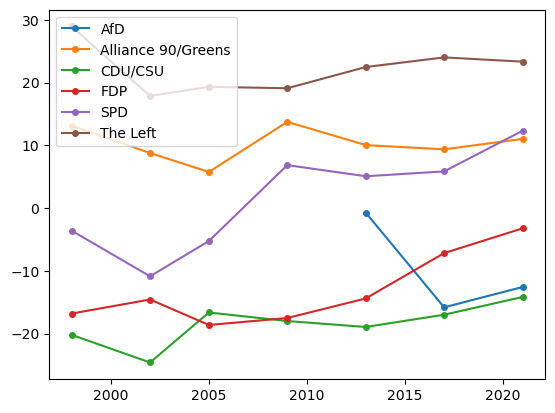

In [ ]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df_d2v.groupby('party_name'):
    ax.plot(group.election, group.d2v_d1, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [ ]:
df_d2v.to_csv('data/py_outputs/r&c_gen.csv', index=False)

## Doc2Vec scaling - Germany, environment
 

In [129]:
manifesto_deu_env = manifesto_deu[manifesto_deu.code_extract.isin([410,416,501])].reset_index(drop=True)


In [130]:
manifesto_deu_env.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Sie haben die Wahl zwischen dem Erhalt unserer...,1998,416.0,33,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,wahl erhalt unserer natürlichen lebensgrundlag...,41113_1998
1,"BÜNDNIS 90/DIE GRÜNEN stehen für Nachhaltigkeit,",1998,416.0,36,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,bündnis grünen stehen nachhaltigkeit,41113_1998
2,Wir wollen die Bundesrepublik ökologisch moder...,1998,416.0,40,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,bundesrepublik ökologisch modernisieren,41113_1998
3,Tatsächlich hat die Bundesrepublik von der Glo...,1998,410.0,60,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41000,410,right,Environment,tatsächlich bundesrepublik globalisierung prof...,41113_1998
4,Sie wurde Exportvizeweltmeister,1998,410.0,61,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41000,410,right,Environment,wurde exportvizeweltmeister,41113_1998


In [131]:
outputs_stream = phraseIterator(manifesto_deu_env,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [132]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_env, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [133]:
model.train(corpusIterator(manifesto_deu_env, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [134]:
embed_dict = d2v_reduct(model)

In [140]:
d2v_env = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_env.index.name = 'party_election'
d2v_env.reset_index(inplace=True)

In [141]:
d2v_env[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_env.iloc[:,1:])

In [142]:
d2v_env = d2v_env[['party_election','d2v_d1', 'd2v_d2']]

In [143]:
d2v_env[['party', 'election']] = d2v_env['party_election'].str.split('_', expand=True)
d2v_env.loc[:,'election'] = d2v_env['election'].astype(int)
d2v_env.loc[:,'party_name'] = d2v_env['party'].astype(str).apply(party_deu)
d2v_env = d2v_env[d2v_env.party_name!='Other']

In [144]:
d2v_env

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-4.073770,-1.343753,41113,1998,Alliance 90/Greens
1,41113_2002,-3.335110,-0.788837,41113,2002,Alliance 90/Greens
2,41113_2005,-3.172856,-0.304541,41113,2005,Alliance 90/Greens
3,41113_2009,-4.069789,-0.800361,41113,2009,Alliance 90/Greens
4,41113_2013,-5.410682,-2.435567,41113,2013,Alliance 90/Greens
5,41113_2017,-5.592213,6.774652,41113,2017,Alliance 90/Greens
6,41113_2021,-6.140067,3.948855,41113,2021,Alliance 90/Greens
7,41221_1998,-0.382644,-0.121831,41221,1998,The Left
8,41221_2002,6.575430,0.310604,41221,2002,The Left
9,41222_2005,6.283983,0.283328,41222,2005,The Left


In [145]:
d2v_env.to_csv('data/py_outputs/r&c_env.csv', index=False)

## Doc2Vec scaling - Germany, decentralization    
 

In [146]:
manifesto_deu_regions = manifesto_deu[manifesto_deu.code_extract.isin([301,302,305])].reset_index(drop=True)


In [147]:
outputs_stream = phraseIterator(manifesto_deu_regions,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [148]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_regions, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [149]:
model.train(corpusIterator(manifesto_deu_regions, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [150]:
embed_dict = d2v_reduct(model)

In [151]:
d2v_regions = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_regions.index.name = 'party_election'
d2v_regions.reset_index(inplace=True)

In [152]:
d2v_regions[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_regions.iloc[:,1:])

In [153]:
d2v_regions = d2v_regions[['party_election','d2v_d1', 'd2v_d2']]
d2v_regions[['party', 'election']] = d2v_regions['party_election'].str.split('_', expand=True)
d2v_regions.loc[:,'election'] = d2v_regions['election'].astype(int)
d2v_regions.loc[:,'party_name'] = d2v_regions['party'].astype(str).apply(party_deu)
d2v_regions = d2v_regions[d2v_regions.party_name!='Other']

In [154]:
d2v_regions

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,0.307181,0.000915,41113,1998,Alliance 90/Greens
1,41113_2002,-0.276856,-0.003150,41113,2002,Alliance 90/Greens
2,41113_2005,-2.754003,-0.005792,41113,2005,Alliance 90/Greens
3,41113_2009,-5.541935,-0.112459,41113,2009,Alliance 90/Greens
4,41113_2013,-6.473772,-0.318040,41113,2013,Alliance 90/Greens
5,41113_2017,-2.201565,0.001005,41113,2017,Alliance 90/Greens
6,41113_2021,-2.986346,-0.016744,41113,2021,Alliance 90/Greens
7,41221_1998,0.440488,-0.027220,41221,1998,The Left
8,41221_2002,-0.662426,-0.045490,41221,2002,The Left
9,41222_2005,2.598467,-0.031105,41222,2005,The Left


In [155]:
d2v_regions.to_csv('data/py_outputs/r&c_regions.csv', index=False)

## Doc2Vec scaling - Germany, economy
 

In [156]:
manifesto_deu_econ = manifesto_deu[manifesto_deu.code_extract.isin([401,402,403,404,409,412,413,414])].reset_index(drop=True)


In [157]:
manifesto_deu_econ.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Auf der Einnahmeseite stehen: ? Einführung ein...,1998,403.0,178,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,40300,403,left,Economy,einnahmeseite stehen einführung energiesteuer,41113_1998
1,? Erhöhung der Mineralölsteuer und Einführung ...,1998,403.0,179,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,40300,403,left,Economy,erhöhung mineralölsteuer einführung schwerverk...,41113_1998
2,Mögliche Überschüsse wollen wir den Bürgerinne...,1998,401.0,184,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,40100,401,right,Economy,mögliche überschüsse bürgerinnen bürgern zurüc...,41113_1998
3,Das gesamte Konzept ist zunächst auf 10 Jahre ...,1998,404.0,191,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,40400,404,left,Economy,gesamte konzept zunächst jahre angelegt,41113_1998
4,Für energieintensive Branchen wollen wir in di...,1998,402.0,192,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,40200,402,right,Economy,energieintensive branchen zeitraum anpassungsh...,41113_1998


In [158]:
outputs_stream = phraseIterator(manifesto_deu_econ,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [159]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_econ, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [160]:
model.train(corpusIterator(manifesto_deu_econ, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [161]:
embed_dict = d2v_reduct(model)

In [162]:
d2v_econ = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_econ.index.name = 'party_election'
d2v_econ.reset_index(inplace=True)

In [163]:
d2v_econ[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_econ.iloc[:,1:])

In [164]:
d2v_econ = d2v_econ[['party_election','d2v_d1', 'd2v_d2']]
d2v_econ[['party', 'election']] = d2v_econ['party_election'].str.split('_', expand=True)
d2v_econ.loc[:,'election'] = d2v_econ['election'].astype(int)
d2v_econ.loc[:,'party_name'] = d2v_econ['party'].astype(str).apply(party_deu)
d2v_econ = d2v_econ[d2v_econ.party_name!='Other']

In [165]:
d2v_econ

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-0.919727,0.106927,41113,1998,Alliance 90/Greens
1,41113_2002,1.785405,-0.067275,41113,2002,Alliance 90/Greens
2,41113_2005,-1.221800,-0.242326,41113,2005,Alliance 90/Greens
3,41113_2009,-2.387244,0.491935,41113,2009,Alliance 90/Greens
4,41113_2013,-3.525442,2.751480,41113,2013,Alliance 90/Greens
5,41113_2017,-2.610518,2.568057,41113,2017,Alliance 90/Greens
6,41113_2021,-3.367459,1.978067,41113,2021,Alliance 90/Greens
7,41221_1998,3.615401,0.331760,41221,1998,The Left
8,41221_2002,2.122628,0.168835,41221,2002,The Left
9,41222_2005,4.610432,0.344567,41222,2005,The Left


In [166]:
d2v_econ.to_csv('data/py_outputs/r&c_econ.csv', index=False)

## Doc2Vec scaling - Germany, EU integration
 

In [167]:
manifesto_deu_eu = manifesto_deu[manifesto_deu.code_extract.isin([108,110])].reset_index(drop=True)


In [168]:
manifesto_deu_eu.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Mehr Demokratie und demokratische Kontrolle fo...,1998,110.0,1693,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,11000,110,right,European integration,mehr demokratie demokratische kontrolle forder...,41113_1998
1,Es darf keine Ausweitung der Kompetenzen europ...,1998,110.0,1694,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,11000,110,right,European integration,darf ausweitung kompetenzen europäischer einri...,41113_1998
2,Die Abschottung der europäischen Grenzen und d...,1998,110.0,1783,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,11000,110,right,European integration,abschottung europäischen grenzen elektronische...,41113_1998
3,Auf dem Weg von Bonn nach Brüssel darf die Dem...,1998,110.0,2109,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,11000,110,right,European integration,bonn brüssel darf demokratie strecke bleiben,41113_1998
4,Gemessen an den Notwendigkeiten einer demokrat...,1998,110.0,2152,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,11000,110,right,European integration,gemessen notwendigkeiten demokratischen politi...,41113_1998


In [169]:
outputs_stream = phraseIterator(manifesto_deu_eu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [170]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_eu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [171]:
model.train(corpusIterator(manifesto_deu_eu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [172]:
embed_dict = d2v_reduct(model)

In [173]:
d2v_eu = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_eu.index.name = 'party_election'
d2v_eu.reset_index(inplace=True)

In [174]:
d2v_eu[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_eu.iloc[:,1:])

In [175]:
d2v_eu = d2v_eu[['party_election','d2v_d1', 'd2v_d2']]
d2v_eu[['party', 'election']] = d2v_eu['party_election'].str.split('_', expand=True)
d2v_eu.loc[:,'election'] = d2v_eu['election'].astype(int)
d2v_eu.loc[:,'party_name'] = d2v_eu['party'].astype(str).apply(party_deu)
d2v_eu = d2v_eu[d2v_eu.party_name!='Other']

In [176]:
d2v_eu

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,6.685651,-0.004877,41113,1998,Alliance 90/Greens
1,41113_2002,2.844560,-0.002271,41113,2002,Alliance 90/Greens
2,41113_2005,-1.335936,-0.003361,41113,2005,Alliance 90/Greens
3,41113_2009,-1.977605,-0.029492,41113,2009,Alliance 90/Greens
4,41113_2013,-5.433958,-0.045591,41113,2013,Alliance 90/Greens
5,41113_2017,-6.109057,-0.080776,41113,2017,Alliance 90/Greens
6,41113_2021,-7.790902,-0.145690,41113,2021,Alliance 90/Greens
7,41221_1998,11.039128,-0.009864,41221,1998,The Left
8,41221_2002,4.603225,0.002606,41221,2002,The Left
9,41222_2005,2.967481,0.000601,41222,2005,The Left


In [177]:
d2v_eu.to_csv('data/py_outputs/r&c_eu.csv', index=False)

## Doc2Vec scaling - Germany, welfare
 

In [178]:
manifesto_deu_wf = manifesto_deu[manifesto_deu.code_extract.isin([503,504,505,701,702])].reset_index(drop=True)


In [179]:
manifesto_deu_wf.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,"soziale Gerechtigkeit,",1998,503.0,37,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50300,503,left,Social Welfare,soziale gerechtigkeit,41113_1998
1,und Gleichberechtigung der Frauen,1998,503.0,39,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50300,503,left,Social Welfare,gleichberechtigung frauen,41113_1998
2,Wir wollen die Erwerbslosigkeit aktiv bekämpfen,1998,701.0,41,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,70100,701,left,Social Welfare,erwerbslosigkeit aktiv bekämpfen,41113_1998
3,Wir wollen den Sozialstaat durch Erneuerung si...,1998,504.0,42,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50400,504,left,Social Welfare,sozialstaat erneuerung sichern,41113_1998
4,Soziale Unsicherheit ist allgemein geworden,1998,503.0,52,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50300,503,left,Social Welfare,soziale unsicherheit allgemein geworden,41113_1998


In [180]:
outputs_stream = phraseIterator(manifesto_deu_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [181]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [182]:
model.train(corpusIterator(manifesto_deu_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [183]:
embed_dict = d2v_reduct(model)

In [184]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [185]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [186]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]
d2v_wf[['party', 'election']] = d2v_wf['party_election'].str.split('_', expand=True)
d2v_wf.loc[:,'election'] = d2v_wf['election'].astype(int)
d2v_wf.loc[:,'party_name'] = d2v_wf['party'].astype(str).apply(party_deu)
d2v_wf = d2v_wf[d2v_wf.party_name!='Other']

In [187]:
d2v_wf

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-1.406845,-5.588585,41113,1998,Alliance 90/Greens
1,41113_2002,-3.181870,-1.262894,41113,2002,Alliance 90/Greens
2,41113_2005,-4.092883,-1.353518,41113,2005,Alliance 90/Greens
3,41113_2009,-4.391301,0.074377,41113,2009,Alliance 90/Greens
4,41113_2013,-4.551848,7.201283,41113,2013,Alliance 90/Greens
5,41113_2017,-3.406011,17.015837,41113,2017,Alliance 90/Greens
6,41113_2021,-2.173615,24.141623,41113,2021,Alliance 90/Greens
7,41221_1998,1.121320,-4.874818,41221,1998,The Left
8,41221_2002,1.386937,-3.408592,41221,2002,The Left
9,41222_2005,1.673967,-1.972054,41222,2005,The Left


In [188]:
d2v_wf.to_csv('data/py_outputs/r&c_wf.csv', index=False)

## Doc2Vec scaling - Germany, immigration
 

In [189]:
manifesto_deu_imm = manifesto_deu[manifesto_deu.code_extract.isin([601,602,607,608])].reset_index(drop=True)


In [190]:
manifesto_deu_imm.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Wir stellen uns der Verantwortung für die deut...,1998,602.0,1714,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,60200,602,left,Immigration,stellen verantwortung deutsche geschichte,41113_1998
1,"Wir setzen uns für die volle Anerkennung, rech...",1998,602.0,1715,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,60200,602,left,Immigration,setzen volle anerkennung rechtliche rehabiliti...,41113_1998
2,Wir wollen ein umfassendes Rehabilitierungsges...,1998,602.0,1716,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,60200,602,left,Immigration,umfassendes rehabilitierungsgesetz errichtung ...,41113_1998
3,Erinnerungs- und Dokumentationsarbeit ist auch...,1998,602.0,1718,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,60200,602,left,Immigration,erinnerungs dokumentationsarbeit vergessenen o...,41113_1998
4,Das Bundesarchivgesetz darf nicht weiterhin di...,1998,602.0,1719,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,60200,602,left,Immigration,bundesarchivgesetz darf weiterhin geschichtlic...,41113_1998


In [191]:
outputs_stream = phraseIterator(manifesto_deu_imm,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [192]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_imm, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [193]:
model.train(corpusIterator(manifesto_deu_imm, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [194]:
embed_dict = d2v_reduct(model)

In [195]:
d2v_imm = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_imm.index.name = 'party_election'
d2v_imm.reset_index(inplace=True)

In [196]:
d2v_imm[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_imm.iloc[:,1:])

In [197]:
d2v_imm = d2v_imm[['party_election','d2v_d1', 'd2v_d2']]
d2v_imm[['party', 'election']] = d2v_imm['party_election'].str.split('_', expand=True)
d2v_imm.loc[:,'election'] = d2v_imm['election'].astype(int)
d2v_imm.loc[:,'party_name'] = d2v_imm['party'].astype(str).apply(party_deu)
d2v_imm = d2v_imm[d2v_imm.party_name!='Other']

In [198]:
d2v_imm

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,2.295121,0.010642,41113,1998,Alliance 90/Greens
1,41113_2002,4.614503,0.010809,41113,2002,Alliance 90/Greens
2,41113_2005,1.860590,-0.008243,41113,2005,Alliance 90/Greens
3,41113_2009,2.719673,0.002890,41113,2009,Alliance 90/Greens
4,41113_2013,-4.366391,-0.042983,41113,2013,Alliance 90/Greens
5,41113_2017,-7.042207,-0.366373,41113,2017,Alliance 90/Greens
6,41113_2021,-6.211401,-0.095873,41113,2021,Alliance 90/Greens
7,41221_1998,4.473495,0.012958,41221,1998,The Left
8,41221_2002,5.872280,0.015265,41221,2002,The Left
9,41222_2005,8.634387,0.018176,41222,2005,The Left


In [199]:
d2v_imm.to_csv('data/py_outputs/r&c_imm.csv', index=False)

## Doc2Vec scaling - Germany, environment protection
 

In [22]:
manifesto_deu_ep = manifesto_deu[manifesto_deu.code_extract.isin([501])].reset_index(drop=True)


In [23]:
manifesto_deu_ep.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Deutschland belastet die Erdatmosphäre durch k...,1998,501.0,66,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50100,501,left,Environment,deutschland belastet erdatmosphäre klimaschädl...,41113_1998
1,Die Bundesregierung fördert den Auto- und Flug...,1998,501.0,67,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50100,501,left,Environment,bundesregierung fördert auto flugverkehr hohe ...,41113_1998
2,Längst sind die Auswirkungen lokaler Umweltdes...,1998,501.0,159,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50100,501,left,Environment,längst auswirkungen lokaler umweltdesaster glo...,41113_1998
3,Umweltschutz steht heute nicht im Mittelpunkt ...,1998,501.0,161,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50100,501,left,Environment,umweltschutz steht heute mittelpunkt öffentlic...,41113_1998
4,Längst sicher geglaubte Errungenschaften der U...,1998,501.0,162,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,50100,501,left,Environment,längst sicher geglaubte errungenschaften umwel...,41113_1998


In [24]:
outputs_stream = phraseIterator(manifesto_deu_ep,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [25]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_ep, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [26]:
model.train(corpusIterator(manifesto_deu_ep, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch


Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [27]:
embed_dict = d2v_reduct(model)

In [28]:
d2v_ep = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_ep.index.name = 'party_election'
d2v_ep.reset_index(inplace=True)

In [31]:
d2v_ep[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_ep.iloc[:,1:])

In [32]:
d2v_ep = d2v_ep[['party_election','d2v_d1', 'd2v_d2']]
d2v_ep[['party', 'election']] = d2v_ep['party_election'].str.split('_', expand=True)
d2v_ep.loc[:,'election'] = d2v_ep['election'].astype(int)
d2v_ep.loc[:,'party_name'] = d2v_ep['party'].astype(str).apply(party_deu)
d2v_ep = d2v_ep[d2v_ep.party_name!='Other']

In [33]:
d2v_ep

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-3.040972,-0.092104,41113,1998,Alliance 90/Greens
1,41113_2002,-3.381074,-0.069271,41113,2002,Alliance 90/Greens
2,41113_2005,-5.119774,-0.045097,41113,2005,Alliance 90/Greens
3,41113_2009,-5.680517,-0.603039,41113,2009,Alliance 90/Greens
4,41113_2013,-7.334694,1.963245,41113,2013,Alliance 90/Greens
5,41113_2017,-6.347797,-0.407871,41113,2017,Alliance 90/Greens
6,41113_2021,-6.696496,-0.292782,41113,2021,Alliance 90/Greens
7,41221_1998,4.730360,0.032540,41221,1998,The Left
8,41221_2002,8.459284,0.070225,41221,2002,The Left
9,41222_2005,4.456810,0.021042,41222,2005,The Left


In [34]:
d2v_ep.to_csv('data/py_outputs/r&c_ep.csv', index=False)

## Doc2Vec scaling - Germany, growth vs anti growth
 

In [35]:
manifesto_deu_growth = manifesto_deu[manifesto_deu.code_extract.isin([410,416])].reset_index(drop=True)


In [36]:
manifesto_deu_growth.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,lrn,topic,text_cleaned,party_election
0,Sie haben die Wahl zwischen dem Erhalt unserer...,1998,416.0,33,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,wahl erhalt unserer natürlichen lebensgrundlag...,41113_1998
1,"BÜNDNIS 90/DIE GRÜNEN stehen für Nachhaltigkeit,",1998,416.0,36,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,bündnis grünen stehen nachhaltigkeit,41113_1998
2,Wir wollen die Bundesrepublik ökologisch moder...,1998,416.0,40,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41600,416,left,Environment,bundesrepublik ökologisch modernisieren,41113_1998
3,Tatsächlich hat die Bundesrepublik von der Glo...,1998,410.0,60,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41000,410,right,Environment,tatsächlich bundesrepublik globalisierung prof...,41113_1998
4,Sie wurde Exportvizeweltmeister,1998,410.0,61,41113_199809,41,41113,Germany,Bündnis‘90/Die Grünen,Alliance‘90/Greens,41000,410,right,Environment,wurde exportvizeweltmeister,41113_1998


In [37]:
outputs_stream = phraseIterator(manifesto_deu_growth,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [38]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_growth, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [39]:
model.train(corpusIterator(manifesto_deu_growth, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch


Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [40]:
embed_dict = d2v_reduct(model)

In [41]:
d2v_growth = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_growth.index.name = 'party_election'
d2v_growth.reset_index(inplace=True)

In [42]:
d2v_growth[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_growth.iloc[:,1:])

In [43]:
d2v_growth = d2v_growth[['party_election','d2v_d1', 'd2v_d2']]
d2v_growth[['party', 'election']] = d2v_growth['party_election'].str.split('_', expand=True)
d2v_growth.loc[:,'election'] = d2v_growth['election'].astype(int)
d2v_growth.loc[:,'party_name'] = d2v_growth['party'].astype(str).apply(party_deu)
d2v_growth = d2v_growth[d2v_growth.party_name!='Other']

In [44]:
d2v_growth

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,7.384253,0.009578,41113,1998,Alliance 90/Greens
1,41113_2002,4.454010,0.002863,41113,2002,Alliance 90/Greens
2,41113_2005,-4.667036,0.001457,41113,2005,Alliance 90/Greens
3,41113_2009,0.051708,0.006977,41113,2009,Alliance 90/Greens
4,41113_2013,8.144320,0.076161,41113,2013,Alliance 90/Greens
5,41113_2017,9.918032,0.688072,41113,2017,Alliance 90/Greens
6,41113_2021,11.117330,-0.551940,41113,2021,Alliance 90/Greens
7,41221_1998,2.643445,-0.012457,41221,1998,The Left
8,41221_2002,-5.085232,-0.009762,41221,2002,The Left
9,41222_2005,-10.220384,-0.001522,41222,2005,The Left


In [45]:
d2v_growth.to_csv('data/py_outputs/r&c_growth.csv', index=False)

# Scale position scores for all countries (released dataset + model)

## Retrain for the entire dataset with all languages

In [4]:
manifesto_org = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [5]:
manifesto_other = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8")

In [6]:
manifesto_full = pd.concat([manifesto_org, manifesto_other])

In [7]:
manifesto_full.head()

,text,election,code,pos,party_code,country,party,countryname,name,name_english
0,Miljöpartiet de Gröna går till val på en polit...,2006,408,1,11110_200609,11,11110,Sweden,Miljöpartiet de Gröna,Green Ecology Party
1,"fler företag,",2006,402,2,11110_200609,11,11110,Sweden,Miljöpartiet de Gröna,Green Ecology Party
2,"levande landsbygd,",2006,301,3,11110_200609,11,11110,Sweden,Miljöpartiet de Gröna,Green Ecology Party
3,nya livschanser,2006,504,4,11110_200609,11,11110,Sweden,Miljöpartiet de Gröna,Green Ecology Party
4,och ett långsiktigt miljöansvar.,2006,501,5,11110_200609,11,11110,Sweden,Miljöpartiet de Gröna,Green Ecology Party


In [8]:
manifesto_full = manifesto_full[(manifesto_full.code.notna()) & ~(manifesto_full.code == 'H')].reset_index(drop=True)

In [9]:
manifesto_full['code_long'] = manifesto_full['code'].apply(subcode_trans)
manifesto_full['code_extract'] = manifesto_full['code_long'].astype(str).apply(extract_code)



In [10]:
manifesto_full['lrn'] = manifesto_full.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_full['topic'] = manifesto_full['code_extract'].apply(topic_code)

In [11]:
manifesto_full.groupby('lrn').count()

,text,election,code,pos,party_code,country,party,countryname,name,name_english,code_long,code_extract,topic
lrn,,,,,,,,,,,,,
left,493433,493433,493433,493433,493433,493433,493433,493433,493433,493433,493433,493433,493433
neutral,298939,298939,298939,298939,298939,298939,298939,298939,298939,298939,298939,298939,298939
right,142905,142905,142905,142905,142905,142905,142905,142905,142905,142905,142905,142905,142905


In [12]:
manifesto_full.groupby(['topic'])['lrn'].value_counts().unstack(fill_value=0)

lrn,left,neutral,right
topic,,,
Agriculture,2418,19864,2157
Civil Rights,27744,64002,16479
Decentralization,25781,0,19877
Defense,5020,0,11478
Economy,55729,0,43864
Education,46915,0,662
Environment,85348,0,13824
European integration,14194,0,6182
Immigration,12520,0,19292


In [11]:
party_group_dict = party_group_func(manifesto_full, 'lrn', group_vars=['countryname','election','topic','party'], threshold=0.2)
party_group_dict

{('Austria', 1999, 'Agriculture', 42110): 'Neutral',
 ('Austria', 1999, 'Agriculture', 42320): 'Neutral',
 ('Austria', 1999, 'Agriculture', 42420): 'Left',
 ('Austria', 1999, 'Agriculture', 42520): 'Neutral',
 ('Austria', 1999, 'Civil Rights', 42110): 'Left',
 ('Austria', 1999, 'Civil Rights', 42320): 'Left',
 ('Austria', 1999, 'Civil Rights', 42420): 'Right',
 ('Austria', 1999, 'Civil Rights', 42520): 'Left',
 ('Austria', 1999, 'Decentralization', 42110): 'Right',
 ('Austria', 1999, 'Decentralization', 42320): 'Right',
 ('Austria', 1999, 'Decentralization', 42420): 'Left',
 ('Austria', 1999, 'Decentralization', 42520): 'Right',
 ('Austria', 1999, 'Defense', 42110): 'Left',
 ('Austria', 1999, 'Defense', 42320): 'Right',
 ('Austria', 1999, 'Defense', 42420): 'Right',
 ('Austria', 1999, 'Defense', 42520): 'Right',
 ('Austria', 1999, 'Economy', 42110): 'Left',
 ('Austria', 1999, 'Economy', 42320): 'Neutral',
 ('Austria', 1999, 'Economy', 42420): 'Right',
 ('Austria', 1999, 'Economy', 4252

In [12]:
results = group_texts(manifesto_full, 
                      ['countryname','election','party','code_long'], 'text', 
                      max_group_factor = 5)

In [13]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [14]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [15]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'code_long']

In [18]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500


In [16]:
manifesto_regrouped.loc[:,'code_extract'] = manifesto_regrouped['code_long'].apply(extract_code)
manifesto_regrouped.loc[:,'lrn'] = manifesto_regrouped.apply(lambda x: lrn_code(x['code_long'], x['code_extract']), axis=1)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['code_extract'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)
manifesto_regrouped.loc[:,'country_party_election'] = manifesto_regrouped.country.str.cat([manifesto_regrouped.party.astype(str), manifesto_regrouped.election.astype(str)], sep='_')


In [17]:
party_group_dict = {tuple(map(str, k)): v for k, v in party_group_dict.items()}


In [18]:
manifesto_regrouped['key'] = list(zip(manifesto_regrouped['country'], manifesto_regrouped['election'], manifesto_regrouped['topic'], manifesto_regrouped['party']))
manifesto_regrouped['party_group'] = manifesto_regrouped['key'].map(party_group_dict)
manifesto_regrouped = manifesto_regrouped.drop(columns=['key'])

In [19]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,party_group
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,Austria_42110_1999,Left
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left


In [23]:
#manifesto_regrouped.to_csv('data/temps/manifesto_regrouped_full_processed.csv', encoding='utf-8', index=False)
#manifesto_full.to_csv('data/temps/manifesto_full_processed.csv', encoding='utf-8', index=False)

In [20]:
manifesto_reduced = manifesto_regrouped[['topic','lrn','text', 'party_group']].reset_index(drop=True)

In [21]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [22]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('party_group')



Casting to class labels:   0%|          | 0/357304 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/357304 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/357304 [00:00<?, ? examples/s]

In [23]:
manifesto_dataset

Dataset({
    features: ['topic', 'lrn', 'text', 'party_group'],
    num_rows: 357304
})

In [24]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/357304 [00:00<?, ? examples/s]

['topic', 'lrn', 'party_group', 'input_ids', 'attention_mask']

In [25]:
train_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn = data_collator)
pred_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)


In [26]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [31]:
num_topics = len(set(manifesto_reduced['topic']))
num_lrs = len(set(manifesto_reduced['lrn']))
num_party_groups = len(set(manifesto_reduced['party_group']))
model = TIPredictWithAttention(config=config, roberta_model=model_name, num_topics=num_topics, num_lrs=num_lrs, num_party_groups= num_party_groups, lora=True, emb_dim = 128).to(device)



In [32]:
model.get_trainable_params(return_count=True)

2604974

In [33]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_lr = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [41]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, criterion_lr, criterion_topic, device, lr_var='lrn',
               topic_var='topic', party_group='party_group')

    

Epoch: 1

Training...
loss: 1.645406  [ 1600/357304].
Reg loss: 0.029510  [ 1600/357304].
Elapsed time: 0:00:20, Estimated remaining time: 1:12:59
loss: 1.616071  [ 3200/357304].
Reg loss: 0.033905  [ 3200/357304].
Elapsed time: 0:00:40, Estimated remaining time: 1:13:20
loss: 1.598329  [ 4800/357304].
Reg loss: 0.033051  [ 4800/357304].
Elapsed time: 0:01:00, Estimated remaining time: 1:13:29
loss: 1.588417  [ 6400/357304].
Reg loss: 0.031799  [ 6400/357304].
Elapsed time: 0:01:20, Estimated remaining time: 1:13:13
loss: 1.583215  [ 8000/357304].
Reg loss: 0.031174  [ 8000/357304].
Elapsed time: 0:01:40, Estimated remaining time: 1:12:25
loss: 1.575127  [ 9600/357304].
Reg loss: 0.031342  [ 9600/357304].
Elapsed time: 0:01:59, Estimated remaining time: 1:12:02
loss: 1.573429  [11200/357304].
Reg loss: 0.031311  [11200/357304].
Elapsed time: 0:02:18, Estimated remaining time: 1:11:19
loss: 1.573085  [12800/357304].
Reg loss: 0.030945  [12800/357304].
Elapsed time: 0:02:38, Estimated re

KeyboardInterrupt: 

In [38]:
model.save_pretrained('results/multilingual/manifesto_full_released/')
tokenizer.save_pretrained('results/multilingual/manifesto_full_released/') 

KeyboardInterrupt: 

In [39]:
topic_count = len(set(manifesto_regrouped['topic']))
lr_count = len(set(manifesto_regrouped['lrn']))
scaling_model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
model=None

In [40]:
loaded_tensors = load_file('results/multilingual/manifesto_full_released/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [41]:
## Compute position scores
position_scores, pred_topics, pred_lrs = scale_func(pred_dataloader, scaling_model, device, reg_value=0.15, by_topic=True, topic_label='topic')

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 0:05:16, Estimated remaining time: 0:53:37
Elapsed time: 0:11:01, Estimated remaining time: 0:50:33
Elapsed time: 0:15:41, Estimated remaining time: 0:42:43
Elapsed time: 0:20:25, Estimated remaining time: 0:36:35
Elapsed time: 0:26:25, Estimated remaining time: 0:32:36
Elapsed time: 0:31:00, Estimated remaining time: 0:26:42
Elapsed time: 0:35:10, Estimated remaining time: 0:20:56
Elapsed time: 0:40:35, Estimated remaining time: 0:16:04
Elapsed time: 0:46:43, Estimated remaining time: 0:11:15
Elapsed time: 0:52:51, Estimated remaining time: 0:06:10
Elapsed time: 0:57:39, Estimated remaining time: 0:00:53
Start computing position scores


In [42]:
list_names = manifesto_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [43]:
manifesto_regrouped.loc[:,'position_scores'] = position_scores.flatten()
manifesto_regrouped.loc[:,'pred_lrn_index'] = pred_lrs
manifesto_regrouped.loc[:,'pred_lrn'] = manifesto_regrouped.pred_lrn_index.map(name_topic_dict)

In [44]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,position_scores,pred_lrn_index,pred_lrn
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,Austria_42110_1999,-0.654691,0,left
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.856232,0,left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,0.408677,2,right
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.823049,0,left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.863337,0,left


In [45]:
manifesto_regrouped.to_csv('results/datasets/manifesto_regrouped_full_scaled.csv', encoding='utf-8')

## Check accuracy

In [46]:
labels = manifesto_dataset['lrn']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_lrs, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [47]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.92,0.90,0.95,0.95
1,0.90,0.91,0.88,0.88
2,0.83,0.87,0.79,0.79


In [48]:
round(res_table.mean(axis=0),2)

f1           0.88
precision    0.89
recall       0.87
accuracy     0.87
dtype: float64

In [49]:
list_names = manifesto_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [50]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.92,0.90,0.95,0.95,left
1,0.90,0.91,0.88,0.88,neutral
2,0.83,0.87,0.79,0.79,right


## Create released dataset (position scores by country-party-election)

In [51]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,position_scores,pred_lrn_index,pred_lrn
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,Austria_42110_1999,-0.654691,0,left
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.856232,0,left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,0.408677,2,right
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.823049,0,left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,-0.863337,0,left


In [52]:
columns  =['country','party', 'election','topic','cs_mean_score', 'cs_se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_regrouped.groupby(['country','party','election','topic']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                             str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
                    str(group.iloc[0,group.columns.get_loc('topic')]),
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8922 entries, 0 to 8921
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        8922 non-null   object 
 1   party          8922 non-null   object 
 2   election       8922 non-null   object 
 3   topic          8922 non-null   object 
 4   cs_mean_score  8922 non-null   float64
 5   cs_se_score    8138 non-null   float64
dtypes: float64(2), object(4)
memory usage: 418.3+ KB


In [54]:
df.head()

,country,party,election,topic,cs_mean_score,cs_se_score
0,Austria,42110,1999,Agriculture,0.033193,NaN
1,Austria,42110,1999,Civil Rights,-0.393406,0.066686
2,Austria,42110,1999,Decentralization,0.465498,0.056954
3,Austria,42110,1999,Defense,-0.608962,0.206155
4,Austria,42110,1999,Economy,0.045509,0.221335


In [55]:
len(set(df['country']))

22

In [56]:
df.to_csv('results/datasets/contextscale_dataset.csv', encoding='utf-8')

## Scale the COALITIONAGREE corpus with full labels information (for official release)

In [57]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [58]:
bert_config = XLMRobertaConfig.from_pretrained(model_name)
config = PretrainedConfig(
    vocab_size = bert_config.vocab_size,
    hidden_size=bert_config.hidden_size,
    num_attention_heads=bert_config.num_attention_heads,
    num_hidden_layers = bert_config.num_hidden_layers,
    hidden_dropout_prob=bert_config.hidden_dropout_prob
)

In [59]:
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [60]:
coalitionagree.head()

,sentence,domain,category2,category3,level,id,country_init,cabinet_year,country
0,1. Abkommen vom Dezember 1945,8,800,80000,0,1,AT,1945,Austria
1,Der Proporz soll nicht nur bei der Bildung der...,9,900,90001,0,2,AT,1945,Austria
2,Staatssekretäre sollen nur in Ausnahmefällen n...,9,900,90004,0,3,AT,1945,Austria
3,Das Programm der Parteien soll in der Erklärun...,9,900,90001,0,4,AT,1945,Austria
4,Die Österreichische Volkspartei bietet den Soz...,9,900,90002,0,5,AT,1945,Austria


In [61]:
results = group_texts(coalitionagree, ['country','cabinet_year','category3'], 'sentence', max_group_factor = 5)

In [62]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split('_', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'code']
coalition_regrouped['code_short'] = coalition_regrouped['code'].apply(extract_code)

In [63]:
coalition_regrouped.head()

,text,labels,country,year,code,code_short
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506


In [64]:
coalition_regrouped['lrn'] = coalition_regrouped.apply(lambda x: lrn_code(x['code'], x['code_short']), axis=1)
coalition_regrouped['topic'] = coalition_regrouped['code_short'].apply(topic_code)

In [65]:
coalition_regrouped.groupby('lrn').count()

,text,labels,country,year,code,code_short,topic
lrn,,,,,,,
left,17997,17997,17997,17997,17997,17997,17997
neutral,15257,15257,15257,15257,15257,15257,15257
right,6033,6033,6033,6033,6033,6033,6033


In [66]:
coalition_regrouped

,text,labels,country,year,code,code_short,lrn,topic
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education
...,...,...,...,...,...,...,...,...
39282,Sverige ska säkra de nationella minoriteternas...,Sweden_2014_70501,Sweden,2014,70501,705,left,Civil Rights
39283,Personer med funktionsnedsättning ska ha möjli...,Sweden_2014_70502,Sweden,2014,70502,705,left,Civil Rights
39284,hbtq-personer,Sweden_2014_70503,Sweden,2014,70503,705,left,Civil Rights
39285,"särskilt kvinnor, Insatser för kvinnors egenfö...",Sweden_2014_70602,Sweden,2014,70602,706,left,Civil Rights


In [67]:
cagree_reduced = coalition_regrouped[['lrn', 'topic','text','country']]

In [69]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('lrn')
cagree_dataset = cagree_dataset.class_encode_column('topic')
cagree_dataset = cagree_dataset.class_encode_column('country')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [70]:
## Retrieve layers up until the lr_count
topic_count = 12 ## number of classes for topic
lr_count = 3 ## number of classes for ideology
model = TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_full_released/model.safetensors')
model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [71]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

['lrn', 'topic', 'country', 'topic_lrn', 'input_ids', 'attention_mask']

In [72]:
train_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn = data_collator)
pred_dataloader = DataLoader(tokenized_dataset, batch_size=32, shuffle=False, collate_fn = data_collator)


In [73]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_lr = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [74]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, criterion_lr, criterion_topic, device,sparse_fraction=0.8,topic_var='topic', lr_var='lrn', country_var='country')


Epoch: 1

Training...
loss: 0.685274  [ 1600/39287].
Elapsed time: 0:00:19, Estimated remaining time: 0:07:17
loss: 0.668667  [ 3200/39287].
Elapsed time: 0:00:36, Estimated remaining time: 0:06:47
loss: 0.641883  [ 4800/39287].
Elapsed time: 0:00:54, Estimated remaining time: 0:06:28
loss: 0.611958  [ 6400/39287].
Elapsed time: 0:01:12, Estimated remaining time: 0:06:09
loss: 0.598642  [ 8000/39287].
Elapsed time: 0:01:30, Estimated remaining time: 0:05:51
loss: 0.587624  [ 9600/39287].
Elapsed time: 0:01:48, Estimated remaining time: 0:05:33
loss: 0.575114  [11200/39287].
Elapsed time: 0:02:06, Estimated remaining time: 0:05:16
loss: 0.565192  [12800/39287].
Elapsed time: 0:02:24, Estimated remaining time: 0:04:58
loss: 0.557401  [14400/39287].
Elapsed time: 0:02:42, Estimated remaining time: 0:04:41
loss: 0.552712  [16000/39287].
Elapsed time: 0:03:00, Estimated remaining time: 0:04:22
loss: 0.548315  [17600/39287].
Elapsed time: 0:03:18, Estimated remaining time: 0:04:04
loss: 0.54

In [75]:
model.save_pretrained('results/multilingual/cagree_full_released/')
tokenizer.save_pretrained('results/multilingual/cagree_full_released/') 

('results/multilingual/cagree_full_released/tokenizer_config.json',
 'results/multilingual/cagree_full_released/special_tokens_map.json',
 'results/multilingual/cagree_full_released/sentencepiece.bpe.model',
 'results/multilingual/cagree_full_released/added_tokens.json',
 'results/multilingual/cagree_full_released/tokenizer.json')

In [76]:
## Save model to the cloud (only done by the author)
#user = "hunghvnguyen"
#model_name = "contextscale-coalitionagree-qlora"
#model_id = f"{user}/{model_name}"
#model.push_to_hub(model_id)


In [77]:
## Reload the model for inference
topic_count = 12 ## number of classes for topic
lr_count = 3 ## number of classes for ideology
scaling_model =  TLRRPredict(config, model_name, topic_count, lr_count, lora=True).to(device)
loaded_tensors = load_file('results/multilingual/cagree_full_released/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [78]:
position_scores, pred_topics, pred_lrs = scale_func(pred_dataloader, scaling_model, device, reg_value=0.15, by_topic=True,topic_label='topic')

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 0:05:26, Estimated remaining time: 0:01:15
Start computing position scores


In [79]:
cagree_full = coalition_regrouped.copy()

In [80]:
cagree_full.loc[:,'position_scores_full'] = position_scores.flatten()
cagree_full.loc[:,'pred_topics_full'] = pred_topics
cagree_full.loc[:,'pred_lr_full'] = pred_lrs



In [81]:
labels = cagree_dataset['lrn']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_lrs, average=None)
matrix = confusion_matrix(labels, pred_lrs)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [82]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.94,0.93,0.95,0.95
1,0.95,0.95,0.96,0.96
2,0.86,0.90,0.81,0.81


In [83]:
cagree_full.head()

,text,labels,country,year,code,code_short,lrn,topic,position_scores_full,pred_topics_full,pred_lr_full
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria_1945_30301,Austria,1945,30301,303,neutral,Other,0.010260,10,1
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria_1945_30303,Austria,1945,30303,303,neutral,Other,-0.186442,10,1
2,über die Behandlung der Nationalsozialisten,Austria_1945_30506,Austria,1945,30506,305,right,Decentralization,-0.037105,2,1
3,sowie über die Verstaatlichung werden in Aussi...,Austria_1945_41301,Austria,1945,41301,413,left,Economy,0.570951,4,2
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria_1945_50602,Austria,1945,50602,506,left,Education,-0.783757,5,0


In [84]:
cagree_full.to_csv('results/datasets/cagree_scaled_full.csv', index=False)